<img align="left" src="https://statics.phbs.pku.edu.cn/uploadfile/2018/0119/20180119080526567.png" style="margin-top:50px">
<h1 align="right" style="margin-top:60px">Machine Learning for Finance (FIN 570) </h1>
<h1 align="right" style="margin-top:20px">Module 1, 2021-2022 Fall </h1>

<h1 align="center" style="margin-top:40px">Sentiment Analysis on Central Bank Statement</h1>

<center>
<font color=black size=4 face=times> Team: Hu Xueyang & Zhai Sihan<br>
    Instructor: Jaehyuk Choi<br>
<font color=black size=3 face=times><center>(Last Modified on Nov 21, 2021)
<center>

## 1. Introduction

1. **X:** After we develop crawlers to download documents from FOMC website (Chapter 2), we extract information from the documents with both Doc2Vec (Chapter 3) and Latent Dirichlet Allocation (LDA, Chapter 4). Then we calculate the difference between two consecutive statements (Chapter 5.1) and principal components of the difference (Chapter 5.2), both of which are used for our prediction models.
2. **Y:** We download Federal Funds Rate, short-term and long-term treasury bond yields from Bloomberg (Chapter 5.3). Then we construct Y variables in two ways, i.e. discrete variables and continuous variables (Chapter 5.4).
3. **Influence of Statements:** We first plot the influence of the publication of statements on Y (Chapter 6.1). 
    1. Discrete Y: For discrete Y, we use Random Forest (Chapter 6.2 for original vectors and Chapter 6.3 for principal components), Support Vector Machine (SVM, Chapter 6.4 for original vectors and Chapter 6.5 for principal components) and Dense Neural Network (Chapter 6.6) to do prediction. We also adopt Grid Search to look for appropriate hyper-parameters, and test the accuracy of our model with 5-fold method.
    2. Continuous Y: For continuous Y, we use Dense Neural Network to do prediction (Chapter 6.7).
4. **Explore Minutes:**
    1. Cosine similarity: We calculate the cosine similarity between the statements and minutes of the same meeting, and the similarity between 2 consecutive documents of the same category (Chapter 7.1).
    2. The influence of the publication of minutes: We test the effect of the publication of minutes on the responses of financial market (Chapter 7.2 & 7.3).
5. **Findings:** 
    1. Discrete Y: Random Forest works the best when predicting all kind of response variables, with the highest accuracy and lowest standard deviation. The accuracy is 40.22% (std: 7.58%) for federal funds rate, 50.03% (std: 5.03%) for 10-year bond, and 51.03% (std: 3.32%) for 3-year bond. Models of principal components cannot beat those of original vectors.
    2. Continuous Y: Dense Neural Network model works significantly better for Bond Yields (especially for the 10-year treasury bond yield) than for Federal Funds Rate.
    3. Similartiy between documents: The cosine similarity based on Doc2Vec model outputs is low and volatile, while the similarity based on LDA model outputs is higher and smoother. Similarity between two consecutive statements is much higher than that between two minutes or between the statement and minutes of the same meeting.
    4. Influence of minutes: The influence of minutes on financial markets is not stastically significant.

## 2. Collect HTML Files from FOMC Website

##### Please see [Web Crawler.ipynb](https://github.com/XueyangHu/PHBS_MLF_2021/blob/master/Project/Web%20Crawler.ipynb) under the same repository.

## 3. Analyze HTML Files with Doc2Vec Model

##### We first tried PDF documents before the presentation (see [PDF Processor.ipynb](https://github.com/XueyangHu/PHBS_MLF_2021/blob/master/Project/PDF%20Processor.ipynb)). However, due to the limited number of pdf files available, we tried HTML files after the presentation.

### 3.1 Define functions to preprocess HTML files

Define functions to read HTML files.

In [2]:
from bs4 import BeautifulSoup as bs
import unicodedata
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import os
import numpy as np
import pandas as pd
import re

def html_to_str(file):
    with open(file,encoding='ISO-8859-1') as f:
        contents = f.read().replace('\n',' ').replace('\t',' ')
        clean_text = unicodedata.normalize('NFKD',bs(contents, 'lxml').get_text())
    return clean_text

### 3.2 Construct training samples for Doc2Vec model

In [3]:
html_min_path='./html_min/'
html_stat_path='./html_stat/'
html_min_list=os.listdir(html_min_path)
html_stat_list=os.listdir(html_stat_path)
html_min_list=[i for i in html_min_list if not i.startswith('.')]
html_stat_list=[i for i in html_stat_list if not i.startswith('.')]

In [4]:
# construct TaggedDocument data with sentences
def str_to_sentences(string, tag=False):
    train_content = []
    count = 0
    if string == '':
        print('Cannot process empty string. Please check.')
    else:
        if tag == True:
            for item in string.split('. '):
                try:
                    train_content.append(TaggedDocument(item, [str(count)]))
                    count += 1
                except ValueError:
                    pass
            return train_content
        else:
            for item in string.split('. '):
                try:
                    train_content.append(item)
                except ValueError:
                    pass
            return train_content

In [5]:
# construct TaggedDocument data with documents
def label_doc(docs, labels, tag=True):
    train_content = []
    if tag == True:
        for count, item in enumerate(docs):
            try:
                train_content.append(TaggedDocument(item, [labels[count]]))
            except ValueError:
                pass
        return train_content
    else:
        for item in docs:
            try:
                train_content.append(item)
            except ValueError:
                pass
        return train_content

In [6]:
html_raw_contents = []
for file in html_min_list:
    contents = html_to_str(html_min_path + file)
    html_raw_contents.append(contents)

for file in html_stat_list:
    contents = html_to_str(html_stat_path + file)
    html_raw_contents.append(contents)

train_data  = label_doc(html_raw_contents, html_min_list + html_stat_list)

### 3.3 Build and train a Doc2Vec model

Distributed Memory Model of Paragraph Vectors (PV-DM) by Le and Mikolov (2014):

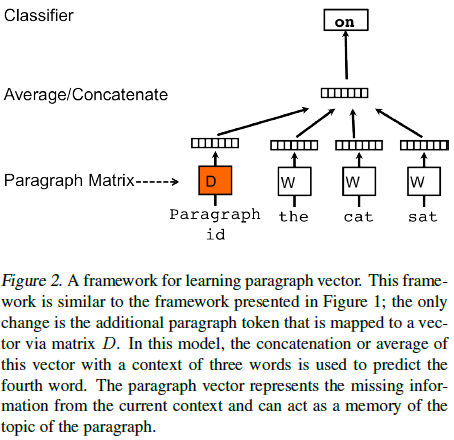

In [7]:
# initialize a Doc2Vec model using distributed memory method
model_html = Doc2Vec(dm=1, vector_size=20, window=5, min_count=2, workers=4)

In [8]:
# train and save the model
model_html.build_vocab(train_data)
model_html.train(train_data, total_examples=model_html.corpus_count, epochs=50)
model_html.save('doc2vec_html.model')

### 3.4 Obtain document vectors

In [9]:
# obtain doc vectors for statements
vec_stat = pd.DataFrame(np.zeros([len(html_stat_list), model_html.vector_size]))

for i in range(len(html_stat_list)):
    file = html_stat_list[i]
    if re.findall(r'\d{8}', file) is not None:
        contents = html_to_str(html_stat_path + file)
        test_content = str_to_sentences(contents, tag=False)
        vec = model_html.infer_vector(test_content)
        vec_stat.loc[i, 'file'] = file.split('.', 1)[0]
        vec_stat.iloc[i, : model_html.vector_size] = vec
        vec_stat.loc[i, 'date'] = re.findall(r'\d{8}', file)
    else:
        pass
vec_stat.set_index('date', inplace=True)
vec_stat.to_excel('vec_stat_html.xlsx')
vec_stat=vec_stat.sort_index()
vec_stat.index=pd.to_datetime(vec_stat.index)
vec_stat

0         1         2         3         4         5  \
date                                                                     
1994-02-04 -0.008525 -0.004142 -0.003645 -0.007631 -0.023503  0.001741   
1994-03-22 -0.014484 -0.024553  0.017419  0.011959  0.012424  0.007778   
1994-04-18 -0.013433 -0.014705 -0.003868  0.009806 -0.005739 -0.021253   
1994-05-17 -0.023727 -0.023009  0.010186  0.001736  0.015344 -0.010242   
1994-08-16  0.000234  0.009672  0.013202  0.022518 -0.008888 -0.023716   
...              ...       ...       ...       ...       ...       ...   
2021-04-28 -0.024121  0.010637 -0.008180  0.021330  0.010713 -0.004367   
2021-06-16 -0.009840 -0.006537 -0.016319  0.017568  0.014245  0.020570   
2021-07-28  0.021759  0.010700 -0.009497 -0.000077 -0.016355  0.011763   
2021-09-22  0.013158  0.022691  0.016206  0.006151  0.002179  0.010079   
2021-11-03  0.012074 -0.022518 -0.003127  0.010262 -0.022394  0.008803   

                   6         7         8         9  ...        11        12  \
date                                                ...                       
1994-02-04  0.018224 -0.022412  0.018384 -0.007739  ...  0.015475  0.006860   
1994-03-22 -0.013378  0.017014  0.021004 -0.003592  ... -0.010831  0.014498   
1994-04-18 -0.006728 -0.019115 -0.000406  0.005678  ... -0.004981  0.013686   
1994-05-17  0.020248 -0.015024  0.005612 -0.015500  ...  0.001399  0.013852   
1994-08-16 -0.006670 -0.022381  0.000559 -0.021006  ...  0.002467  0.019898   
...              ...       ...       ...       ...  ...       ...       ...   
2021-04-28  0.007850  0.015941 -0.006866  0.008954  ... -0.019522  0.009663   
2021-06-16 -0.015763 -0.009321 -0.019354 -0.024355  ... -0.000333  0.002453   
2021-07-28 -0.022977 -0.007454  0.022494  0.013916  ...  0.004335 -0.002642   
2021-09-22  0.000328  0.012967  0.006350  0.001488  ...  0.021786 -0.002505   
2021-11-03 -0.009023  0.016715  0.022096  0.005528  ...  0.011889  0.012933   

                  13        14        15        16        17        18  \
date                                                                     
1994-02-04  0.024058 -0.011134  0.016401  0.003372  0.024359  0.003039   
1994-03-22  0.000042 -0.002014 -0.004550  0.010607  0.010245  0.011844   
1994-04-18  0.024929 -0.005471 -0.023060  0.013292  0.004891 -0.005869   
1994-05-17 -0.013956 -0.010760  0.004694  0.010967 -0.009852 -0.000527   
1994-08-16 -0.009547 -0.007817 -0.020390 -0.005108  0.002850  0.008766   
...              ...       ...       ...       ...       ...       ...   
2021-04-28  0.010408 -0.007992  0.008836  0.018441 -0.006546 -0.008549   
2021-06-16  0.001025 -0.020737  0.021288 -0.011487  0.005683  0.008570   
2021-07-28 -0.004258  0.014161  0.021062  0.003224 -0.001240  0.002532   
2021-09-22  0.019740 -0.016234  0.015369  0.005013 -0.009214  0.014692   
2021-11-03  0.023993 -0.010529 -0.003255 -0.014637 -0.008382  0.006750   

                  19               file  
date                                     
1994-02-04 -0.005585    19940204default  
1994-03-22 -0.014016    19940322default  
1994-04-18 -0.013704    19940418default  
1994-05-17  0.022233    19940517default  
1994-08-16  0.015445    19940816default  
...              ...                ...  
2021-04-28 -0.014217  monetary20210428a  
2021-06-16 -0.020680  monetary20210616a  
2021-07-28  0.013801  monetary20210728a  
2021-09-22  0.024336  monetary20210922a  
2021-11-03 -0.003102  monetary20211103a  

[208 rows x 21 columns]

In [10]:
# obtain doc vectors for minutes
vec_min = pd.DataFrame(np.zeros([len(html_min_list), model_html.vector_size]))
for i in range(len(html_min_list)):
    file = html_min_list[i]
    if re.findall(r'\d{8}', file) is not None:
        contents = html_to_str(html_min_path + file)
        test_content = str_to_sentences(contents, tag=False)
        vec = model_html.infer_vector(test_content)
        vec_min.loc[i, 'file'] = file.split('.', 1)[0]
        vec_min.iloc[i, : model_html.vector_size] = vec
        vec_min.loc[i, 'date'] = re.findall(r'\d{8}', file)
    else:
        pass
vec_min.set_index('date', inplace=True)
vec_min.to_excel('vec_min_html.xlsx')
vec_min=vec_min.sort_index()
vec_min.index=pd.to_datetime(vec_min.index)
vec_min

0         1         2         3         4         5  \
date                                                                     
1993-02-03  2.942175  1.780412 -0.092292  2.989455  1.448538  0.369193   
1993-03-23  0.079501  0.337410 -0.070905  0.336270  0.243740 -0.285141   
1993-05-18  0.248356  0.361824 -0.211024  0.657153  0.193834 -0.057605   
1993-07-07  0.725938  0.331737 -0.149739  0.612186  0.629019 -0.114426   
1993-08-17  0.042671  0.322993 -0.031665  0.320387  0.281376 -0.260151   
...              ...       ...       ...       ...       ...       ...   
2021-03-17 -0.001677 -0.019243 -0.002697  0.020680 -0.003847  0.020618   
2021-04-28 -0.022271 -0.018162 -0.021961  0.011451 -0.004297  0.017621   
2021-06-16  0.013522  0.007167  0.014819 -0.009452 -0.006616 -0.022409   
2021-07-28  0.000793 -0.015154 -0.024180  0.022271  0.016136  0.023887   
2021-09-22 -0.003790 -0.000873 -0.000618  0.017228  0.011465 -0.007089   

                   6         7         8         9  ...        11        12  \
date                                                ...                       
1993-02-03  3.672686 -2.751040 -0.265386  0.407227  ...  1.240084  1.584398   
1993-03-23  0.142462 -0.284833 -0.169519  0.023548  ...  0.166183  0.279895   
1993-05-18  0.186736 -0.423122 -0.273838  0.388279  ...  0.110080  0.262762   
1993-07-07  0.729109 -0.679948  0.507371  0.211751  ... -0.206983  0.483804   
1993-08-17  0.192001 -0.300813 -0.129859  0.020517  ...  0.113386  0.278757   
...              ...       ...       ...       ...  ...       ...       ...   
2021-03-17  0.011376  0.004575  0.006548 -0.002595  ... -0.008957  0.000673   
2021-04-28 -0.011529 -0.020937 -0.019703 -0.022210  ... -0.010658  0.002476   
2021-06-16 -0.017427 -0.005424  0.009212  0.017402  ... -0.004798  0.004855   
2021-07-28 -0.006810 -0.019679 -0.000922  0.014548  ...  0.021808 -0.022386   
2021-09-22  0.023419  0.013438  0.009821  0.016238  ... -0.004387 -0.015049   

                  13        14        15        16        17        18  \
date                                                                     
1993-02-03  1.003332  3.114112  1.753563 -0.382860 -1.117488 -2.769537   
1993-03-23  0.047567  0.034561  0.289242 -0.025300 -0.384545 -0.475066   
1993-05-18  0.111738  0.101045  0.169254 -0.073478 -0.359525 -0.783935   
1993-07-07  0.245412  0.422530  0.549719  0.142900 -0.073024 -1.153433   
1993-08-17  0.081699  0.007400  0.283903 -0.071833 -0.367982 -0.477900   
...              ...       ...       ...       ...       ...       ...   
2021-03-17 -0.001216 -0.010268  0.015089 -0.020955  0.008443  0.021553   
2021-04-28 -0.011725 -0.007685  0.019597 -0.008808 -0.003171 -0.019808   
2021-06-16 -0.009671 -0.006490  0.008367  0.022295  0.007687 -0.021962   
2021-07-28 -0.003470  0.007512  0.024118 -0.016385  0.016137  0.008716   
2021-09-22  0.020424 -0.016418  0.010274 -0.011485 -0.013689 -0.016642   

                  19                 file  
date                                       
1993-02-03 -2.350053          19930203min  
1993-03-23 -0.308341          19930323min  
1993-05-18 -0.607847          19930518min  
1993-07-07 -0.409278          19930707min  
1993-08-17 -0.321104          19930817min  
...              ...                  ...  
2021-03-17 -0.004427  fomcminutes20210317  
2021-04-28  0.010607  fomcminutes20210428  
2021-06-16 -0.017064  fomcminutes20210616  
2021-07-28  0.006468  fomcminutes20210728  
2021-09-22 -0.004538  fomcminutes20210922  

[228 rows x 21 columns]

## 4. Analyze HTML Files with Latent Dirichlet Allocation (LDA) Model

### 4.1 Preprocess HTML files

In [11]:
example=html_to_str('./html_stat/20010418.htm')
example

'  FRB: Press Release -- FOMC statement and Board discount rate action -- April 18, 2001     Release Date: April 18, 2001    For immediate release        The Federal Open Market Committee decided today to lower its target for the federal funds rate by 50 basis points to 4-1/2 percent.  In a related action, the Board of Governors approved a 50 basis point reduction in the discount rate to 4 percent.     The FOMC has reviewed prospects for the economy in light of the information that has become available since its March meeting.  A significant reduction in excess inventories seems well advanced.  Consumption and housing expenditures have held up reasonably well, though activity in these areas has flattened recently.  Although measured productivity probably weakened in the first quarter, the impressive underlying rate of increase that developed in recent years appears to be largely intact.     Nonetheless, capital investment has continued to soften and the persistent erosion in current an

In [12]:
# Remove punctuations
import string
example = example.translate(str.maketrans('', '', string.punctuation))
example = re.sub('\d','',example).lower()

In [13]:
# Remove stop words
from gensim.parsing.preprocessing import remove_stopwords
example = remove_stopwords(example)
example

'frb press release fomc statement board discount rate action april release date april immediate release federal open market committee decided today lower target federal funds rate basis points percent related action board governors approved basis point reduction discount rate percent fomc reviewed prospects economy light information available march meeting significant reduction excess inventories advanced consumption housing expenditures held reasonably activity areas flattened recently measured productivity probably weakened quarter impressive underlying rate increase developed recent years appears largely intact nonetheless capital investment continued soften persistent erosion current expected profitability combination rising uncertainty business outlook poised dampen capital spending going forward potential restraint possible effects earlier reductions equity wealth consumption risk slower growth abroad threatens pace economic activity unacceptably weak consequence committee agreed

In [14]:
# Lemmatize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
 
wnl = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

example_list=[wnl.lemmatize(i,get_wordnet_pos(pos_tag([i])[0][1])) for i in example.split()]

In [15]:
# Stemming
from nltk.stem import SnowballStemmer

snowball_stemmer = SnowballStemmer('english')
example_list = [snowball_stemmer.stem(i) for i in example_list]
example_list

['frb',
 'press',
 'releas',
 'fomc',
 'statement',
 'board',
 'discount',
 'rate',
 'action',
 'april',
 'releas',
 'date',
 'april',
 'immedi',
 'releas',
 'feder',
 'open',
 'market',
 'committe',
 'decid',
 'today',
 'low',
 'target',
 'feder',
 'fund',
 'rate',
 'basi',
 'point',
 'percent',
 'relat',
 'action',
 'board',
 'governor',
 'approv',
 'basi',
 'point',
 'reduct',
 'discount',
 'rate',
 'percent',
 'fomc',
 'review',
 'prospect',
 'economi',
 'light',
 'inform',
 'avail',
 'march',
 'meet',
 'signific',
 'reduct',
 'excess',
 'inventori',
 'advanc',
 'consumpt',
 'hous',
 'expenditur',
 'held',
 'reason',
 'activ',
 'area',
 'flatten',
 'recent',
 'measur',
 'product',
 'probabl',
 'weaken',
 'quarter',
 'impress',
 'underli',
 'rate',
 'increas',
 'develop',
 'recent',
 'year',
 'appear',
 'larg',
 'intact',
 'nonetheless',
 'capit',
 'invest',
 'continu',
 'soften',
 'persist',
 'eros',
 'current',
 'expect',
 'profit',
 'combin',
 'rise',
 'uncertainti',
 'busi',
 'o

In [16]:
from collections import Counter
import operator
import functools

def word_count(text, num):
    words = [word for word in text]
    counter = Counter()
    counter.update(words)
    words_common = counter.most_common(num)
    return words_common, words

In [17]:
def preprocessing(text):
    text=text.translate(str.maketrans('', '', string.punctuation))
    text=re.sub('\d','',text).lower()
    text=re.sub('january|february|march|april|may|june|july|august|september|october|november|december','',text)
    text=remove_stopwords(text)
    wnl = WordNetLemmatizer()
    text_list=[]
    for i in text.split():
        pos=get_wordnet_pos(pos_tag([i])[0][1])
        if pos is not None:
            text_list.append(wnl.lemmatize(i,pos))
        else:
            text_list.append(wnl.lemmatize(i))
    
    #snowball_stemmer = SnowballStemmer('english')
    #return [snowball_stemmer.stem(i) for i in text_list]
    return text_list

### 4.2 Construct training samples for LDA model

We first import HTML files and run preprocessing.

In [18]:
html_stat_contents=[]
for file in html_stat_list:
    contents = html_to_str(html_stat_path + file)
    contents = preprocessing(contents)
    html_stat_contents.append(contents)

html_min_contents=[]
for file in html_min_list:
    contents = html_to_str(html_min_path + file)
    contents = preprocessing(contents)
    html_min_contents.append(contents)

Then, we filter out frequent words without clear meanings. We want to remove those words from the text.

In [19]:
import operator
import functools

word_collection=functools.reduce(operator.concat, html_stat_contents + html_min_contents)

In [20]:
word_count(word_collection, 40)[0]

[('federal', 16372),
 ('market', 15159),
 ('committee', 14147),
 ('reserve', 12811),
 ('rate', 12323),
 ('inflation', 10471),
 ('policy', 10113),
 ('economic', 9613),
 ('bank', 9159),
 ('financial', 9123),
 ('price', 8462),
 ('board', 7041),
 ('increase', 6901),
 ('growth', 6687),
 ('monetary', 6532),
 ('participant', 6371),
 ('remain', 5650),
 ('meeting', 5375),
 ('year', 5284),
 ('security', 5280),
 ('foreign', 5226),
 ('consumer', 5156),
 ('condition', 5001),
 ('quarter', 4982),
 ('member', 4955),
 ('period', 4912),
 ('recent', 4879),
 ('business', 4743),
 ('open', 4656),
 ('governor', 4631),
 ('development', 4490),
 ('data', 4462),
 ('continued', 4453),
 ('decline', 4452),
 ('percent', 4297),
 ('level', 4296),
 ('month', 4210),
 ('fund', 4144),
 ('low', 4068),
 ('rise', 4068)]

We then use `gensim` to build a dictionary.

In [21]:
from gensim import corpora, models, similarities
dictionary=corpora.Dictionary(html_stat_contents+html_min_contents)
dict_len=len(dictionary)

corpus = [dictionary.doc2bow(text) for text in html_stat_contents+html_min_contents]
corpus_tfidf = models.TfidfModel(corpus)[corpus]

### 4.3 Build and train a LDA model
We run the LDA model here and generate the keywords of each cluster and the distance between each documents and each cluster.

In [22]:
num_topics=7
lda = models.LdaModel(corpus_tfidf, num_topics=num_topics, id2word=dictionary,
      alpha=0.01, eta=0.01, minimum_probability=0.001, update_every = 1, chunksize = 100, passes = 1)

In [23]:
# Membership grade
print('This the membership grade for top 10 documents:')
doc_topics = lda.get_document_topics(corpus_tfidf,minimum_probability=0)
for i in range(10):
    topic_idx = np.array(doc_topics[i])[:,1]
    print('%dth document:'%i)
    print(topic_idx)

This the membership grade for top 10 documents:
0th document:
[6.53986761e-04 9.96076047e-01 6.53986761e-04 6.53986761e-04
 6.53986761e-04 6.53986761e-04 6.53986761e-04]
1th document:
[0.00140627 0.26897269 0.72399592 0.00140627 0.00140627 0.00140627
 0.00140627]
2th document:
[5.76122366e-02 9.39120114e-01 6.53524301e-04 6.53524301e-04
 6.53524301e-04 6.53524301e-04 6.53524301e-04]
3th document:
[0.99111211 0.00148131 0.00148131 0.00148131 0.00148131 0.00148131
 0.00148131]
4th document:
[0.7838766  0.20699506 0.00182567 0.00182567 0.00182567 0.00182567
 0.00182567]
5th document:
[5.82279637e-04 9.96506333e-01 5.82279637e-04 5.82279637e-04
 5.82279637e-04 5.82279637e-04 5.82279637e-04]
6th document:
[5.76089311e-04 9.96543467e-01 5.76089311e-04 5.76089311e-04
 5.76089311e-04 5.76089311e-04 5.76089311e-04]
7th document:
[5.99299208e-04 9.96404231e-01 5.99299208e-04 5.99299208e-04
 5.99299208e-04 5.99299208e-04 5.99299208e-04]
8th document:
[0.00138214 0.20447733 0.67342871 0.00138214 0

In [24]:
# Keyword for each topic
for topic_id in range(num_topics):
    print('Keywords for Topic %d:' % topic_id)
    term_distribute_all = lda.get_topic_terms(topicid=topic_id)
    term_distribute = term_distribute_all[:7]
    term_distribute = np.array(term_distribute)
    term_id = term_distribute[:, 0].astype(int)
    print('Word: \t', end='  ')
    for t in term_id:
        print(dictionary.id2token[t], end=' ')
    print('\nProbability：\t', term_distribute[:, 1])

Keywords for Topic 0:
Word: 	  arrangement demand agree relatively expansion equity inventory 
Probability：	 [0.018192   0.01755651 0.0168457  0.01460589 0.01419268 0.01325929
 0.01204632]
Keywords for Topic 1:
Word: 	  mr period quarter decline continued rise staff 
Probability：	 [0.01439627 0.00862702 0.00706984 0.00549042 0.00515929 0.00413995
 0.00410945]
Keywords for Topic 2:
Word: 	  associate sale slightly judged unchanged result position 
Probability：	 [0.03212966 0.02018715 0.01846491 0.01821456 0.01805999 0.01729784
 0.01562225]
Keywords for Topic 3:
Word: 	  page community regulation link h supervision payment 
Probability：	 [0.00287246 0.00219206 0.00217276 0.0021113  0.00141788 0.00138718
 0.00125903]
Keywords for Topic 4:
Word: 	  discount releasefomc unsettled charge page facility lender 
Probability：	 [0.00093428 0.00064994 0.00064983 0.00062361 0.00051727 0.00049061
 0.0004839 ]
Keywords for Topic 5:
Word: 	  intermeeting domestic president hire important briskly accum

### 4.4 Obtain inputs of the prediction model

In [25]:
training_data=pd.DataFrame([[j[1] for j in i] for i in lda.get_document_topics(corpus_tfidf,minimum_probability=0)],
                          index=['st'+re.search(r'\d{8}', i)[0] for i in html_stat_list]+[
                              'mi'+re.search(r'\d{8}', i)[0] for i in html_min_list])

In [26]:
training_data.index.name='date'
training_data=training_data.reset_index()
training_data['type']=training_data.date.str[:2]
training_data.date=pd.to_datetime(training_data.date.str[2:])

In [27]:
training_data

date         0         1         2         3         4         5  \
0   2006-12-12  0.000654  0.996076  0.000654  0.000654  0.000654  0.000654   
1   2002-09-24  0.001406  0.268972  0.723997  0.001406  0.001406  0.001406   
2   2008-01-22  0.057615  0.939117  0.000654  0.000654  0.000654  0.000654   
3   2000-02-02  0.991112  0.001481  0.001481  0.001481  0.001481  0.001481   
4   1998-11-17  0.783836  0.207035  0.001826  0.001826  0.001826  0.001826   
..         ...       ...       ...       ...       ...       ...       ...   
431 2007-09-18  0.186708  0.763904  0.032761  0.000934  0.000934  0.013823   
432 2011-11-02  0.077398  0.865411  0.039761  0.000828  0.000828  0.014946   
433 1996-05-21  0.168338  0.707336  0.100174  0.000937  0.000937  0.021341   
434 2017-05-03  0.076606  0.856232  0.049640  0.000698  0.000698  0.015427   
435 2005-02-02  0.096820  0.746587  0.129939  0.001123  0.001123  0.023286   

            6 type  
0    0.000654   st  
1    0.001406   st  
2    0.000654   st  
3    0.001481   st  
4    0.001826   st  
..        ...  ...  
431  0.000934   mi  
432  0.000828   mi  
433  0.000937   mi  
434  0.000698   mi  
435  0.001123   mi  

[436 rows x 9 columns]

## 5. Prepare Data for the Prediction Model
### 5.1 Merge and differntiate X variables
#### Statements

In [28]:
def diff(df):
    return df-df.shift()

In [29]:
lda_stat=training_data[training_data.type=='st'].drop('type',axis=1).sort_values('date').set_index('date')
lda_stat.columns=['lda_'+str(i) for i in lda_stat.columns]
lda_stat

lda_0     lda_1     lda_2     lda_3     lda_4     lda_5  \
date                                                                     
1994-02-04  0.439699  0.003214  0.544233  0.003214  0.003214  0.003214   
1994-03-22  0.091651  0.096848  0.801333  0.002542  0.002542  0.002542   
1994-04-18  0.091394  0.103219  0.795123  0.002566  0.002566  0.002566   
1994-05-17  0.708511  0.196013  0.088446  0.001758  0.001758  0.001758   
1994-08-16  0.855423  0.135990  0.001718  0.001718  0.001718  0.001718   
...              ...       ...       ...       ...       ...       ...   
2021-04-28  0.000620  0.996280  0.000620  0.000620  0.000620  0.000620   
2021-06-16  0.000618  0.996294  0.000618  0.000618  0.000618  0.000618   
2021-07-28  0.000621  0.996272  0.000621  0.000621  0.000621  0.000621   
2021-09-22  0.000617  0.996296  0.000617  0.000617  0.000617  0.000617   
2021-11-03  0.000611  0.996333  0.000611  0.000611  0.000611  0.000611   

               lda_6  
date                  
1994-02-04  0.003214  
1994-03-22  0.002542  
1994-04-18  0.002566  
1994-05-17  0.001758  
1994-08-16  0.001718  
...              ...  
2021-04-28  0.000620  
2021-06-16  0.000618  
2021-07-28  0.000621  
2021-09-22  0.000617  
2021-11-03  0.000611  

[208 rows x 7 columns]

In [30]:
vec_stat.columns=['vec_'+str(i) for i in vec_stat.columns]
vec_stat

vec_0     vec_1     vec_2     vec_3     vec_4     vec_5  \
date                                                                     
1994-02-04 -0.008525 -0.004142 -0.003645 -0.007631 -0.023503  0.001741   
1994-03-22 -0.014484 -0.024553  0.017419  0.011959  0.012424  0.007778   
1994-04-18 -0.013433 -0.014705 -0.003868  0.009806 -0.005739 -0.021253   
1994-05-17 -0.023727 -0.023009  0.010186  0.001736  0.015344 -0.010242   
1994-08-16  0.000234  0.009672  0.013202  0.022518 -0.008888 -0.023716   
...              ...       ...       ...       ...       ...       ...   
2021-04-28 -0.024121  0.010637 -0.008180  0.021330  0.010713 -0.004367   
2021-06-16 -0.009840 -0.006537 -0.016319  0.017568  0.014245  0.020570   
2021-07-28  0.021759  0.010700 -0.009497 -0.000077 -0.016355  0.011763   
2021-09-22  0.013158  0.022691  0.016206  0.006151  0.002179  0.010079   
2021-11-03  0.012074 -0.022518 -0.003127  0.010262 -0.022394  0.008803   

               vec_6     vec_7     vec_8     vec_9  ...    vec_11    vec_12  \
date                                                ...                       
1994-02-04  0.018224 -0.022412  0.018384 -0.007739  ...  0.015475  0.006860   
1994-03-22 -0.013378  0.017014  0.021004 -0.003592  ... -0.010831  0.014498   
1994-04-18 -0.006728 -0.019115 -0.000406  0.005678  ... -0.004981  0.013686   
1994-05-17  0.020248 -0.015024  0.005612 -0.015500  ...  0.001399  0.013852   
1994-08-16 -0.006670 -0.022381  0.000559 -0.021006  ...  0.002467  0.019898   
...              ...       ...       ...       ...  ...       ...       ...   
2021-04-28  0.007850  0.015941 -0.006866  0.008954  ... -0.019522  0.009663   
2021-06-16 -0.015763 -0.009321 -0.019354 -0.024355  ... -0.000333  0.002453   
2021-07-28 -0.022977 -0.007454  0.022494  0.013916  ...  0.004335 -0.002642   
2021-09-22  0.000328  0.012967  0.006350  0.001488  ...  0.021786 -0.002505   
2021-11-03 -0.009023  0.016715  0.022096  0.005528  ...  0.011889  0.012933   

              vec_13    vec_14    vec_15    vec_16    vec_17    vec_18  \
date                                                                     
1994-02-04  0.024058 -0.011134  0.016401  0.003372  0.024359  0.003039   
1994-03-22  0.000042 -0.002014 -0.004550  0.010607  0.010245  0.011844   
1994-04-18  0.024929 -0.005471 -0.023060  0.013292  0.004891 -0.005869   
1994-05-17 -0.013956 -0.010760  0.004694  0.010967 -0.009852 -0.000527   
1994-08-16 -0.009547 -0.007817 -0.020390 -0.005108  0.002850  0.008766   
...              ...       ...       ...       ...       ...       ...   
2021-04-28  0.010408 -0.007992  0.008836  0.018441 -0.006546 -0.008549   
2021-06-16  0.001025 -0.020737  0.021288 -0.011487  0.005683  0.008570   
2021-07-28 -0.004258  0.014161  0.021062  0.003224 -0.001240  0.002532   
2021-09-22  0.019740 -0.016234  0.015369  0.005013 -0.009214  0.014692   
2021-11-03  0.023993 -0.010529 -0.003255 -0.014637 -0.008382  0.006750   

              vec_19           vec_file  
date                                     
1994-02-04 -0.005585    19940204default  
1994-03-22 -0.014016    19940322default  
1994-04-18 -0.013704    19940418default  
1994-05-17  0.022233    19940517default  
1994-08-16  0.015445    19940816default  
...              ...                ...  
2021-04-28 -0.014217  monetary20210428a  
2021-06-16 -0.020680  monetary20210616a  
2021-07-28  0.013801  monetary20210728a  
2021-09-22  0.024336  monetary20210922a  
2021-11-03 -0.003102  monetary20211103a  

[208 rows x 21 columns]

In [31]:
stat_total=diff(lda_stat).merge(diff(vec_stat.drop('vec_file',axis=1)),
                                left_index=True,right_index=True).dropna()

In [32]:
stat_total

lda_0     lda_1     lda_2     lda_3     lda_4     lda_5  \
date                                                                     
1994-03-22 -0.348048  0.093635  0.257100 -0.000672 -0.000672 -0.000672   
1994-04-18 -0.000257  0.006371 -0.006210  0.000024  0.000024  0.000024   
1994-05-17  0.617117  0.092794 -0.706678 -0.000808 -0.000808 -0.000808   
1994-08-16  0.146912 -0.060024 -0.086728 -0.000040 -0.000040 -0.000040   
1994-11-15  0.132012 -0.133895  0.000377  0.000377  0.000377  0.000377   
...              ...       ...       ...       ...       ...       ...   
2021-04-28  0.000010 -0.000061  0.000010  0.000010  0.000010  0.000010   
2021-06-16 -0.000002  0.000014 -0.000002 -0.000002 -0.000002 -0.000002   
2021-07-28  0.000004 -0.000022  0.000004  0.000004  0.000004  0.000004   
2021-09-22 -0.000004  0.000025 -0.000004 -0.000004 -0.000004 -0.000004   
2021-11-03 -0.000006  0.000036 -0.000006 -0.000006 -0.000006 -0.000006   

               lda_6     vec_0     vec_1     vec_2  ...    vec_10    vec_11  \
date                                                ...                       
1994-03-22 -0.000672 -0.005959 -0.020411  0.021065  ...  0.008745 -0.026306   
1994-04-18  0.000024  0.001051  0.009848 -0.021287  ... -0.036655  0.005850   
1994-05-17 -0.000808 -0.010294 -0.008304  0.014054  ... -0.008109  0.006380   
1994-08-16 -0.000040  0.023961  0.032680  0.003016  ...  0.013179  0.001068   
1994-11-15  0.000377  0.024748 -0.022374 -0.018101  ...  0.024899 -0.008527   
...              ...       ...       ...       ...  ...       ...       ...   
2021-04-28  0.000010 -0.038932 -0.008214 -0.010451  ... -0.005677 -0.007882   
2021-06-16 -0.000002  0.014281 -0.017174 -0.008139  ...  0.039262  0.019189   
2021-07-28  0.000004  0.031599  0.017237  0.006822  ...  0.007498  0.004668   
2021-09-22 -0.000004 -0.008601  0.011991  0.025702  ... -0.029319  0.017451   
2021-11-03 -0.000006 -0.001084 -0.045209 -0.019332  ...  0.027348 -0.009896   

              vec_12    vec_13    vec_14    vec_15    vec_16    vec_17  \
date                                                                     
1994-03-22  0.007639 -0.024017  0.009120 -0.020951  0.007235 -0.014114   
1994-04-18 -0.000813  0.024888 -0.003457 -0.018510  0.002685 -0.005354   
1994-05-17  0.000166 -0.038886 -0.005288  0.027754 -0.002325 -0.014743   
1994-08-16  0.006047  0.004409  0.002943 -0.025084 -0.016075  0.012702   
1994-11-15 -0.008279 -0.012512 -0.014045  0.010147  0.006983 -0.021650   
...              ...       ...       ...       ...       ...       ...   
2021-04-28  0.022919  0.031607 -0.030714  0.023541  0.021024  0.016500   
2021-06-16 -0.007209 -0.009383 -0.012744  0.012452 -0.029929  0.012229   
2021-07-28 -0.005095 -0.005283  0.034898 -0.000227  0.014711 -0.006923   
2021-09-22  0.000137  0.023998 -0.030395 -0.005693  0.001789 -0.007973   
2021-11-03  0.015438  0.004253  0.005705 -0.018624 -0.019650  0.000832   

              vec_18    vec_19  
date                            
1994-03-22  0.008805 -0.008431  
1994-04-18 -0.017714  0.000311  
1994-05-17  0.005343  0.035937  
1994-08-16  0.009293 -0.006787  
1994-11-15 -0.019914 -0.022345  
...              ...       ...  
2021-04-28 -0.011358 -0.032645  
2021-06-16  0.017119 -0.006462  
2021-07-28 -0.006039  0.034481  
2021-09-22  0.012160  0.010535  
2021-11-03 -0.007942 -0.027438  

[207 rows x 27 columns]

In [33]:
stat_original=lda_stat.merge(vec_stat.drop('vec_file',axis=1),
                            left_index=True,right_index=True).dropna()
stat_original.to_excel('stat_original.xlsx')

#### Minutes

In [34]:
lda_min=training_data[training_data.type=='mi'].drop('type',axis=1).sort_values('date').set_index('date')
lda_min.columns=['lda_'+str(i) for i in lda_min.columns]
lda_min

lda_0     lda_1     lda_2     lda_3     lda_4     lda_5  \
date                                                                     
1993-02-03  0.149051  0.717188  0.110846  0.001021  0.001021  0.019853   
1993-03-23  0.140210  0.672853  0.146168  0.001033  0.001033  0.022637   
1993-05-18  0.155728  0.697520  0.121792  0.001041  0.001041  0.021838   
1993-07-07  0.145192  0.695854  0.114465  0.001064  0.001064  0.022861   
1993-08-17  0.153889  0.697328  0.117387  0.001151  0.001151  0.027944   
...              ...       ...       ...       ...       ...       ...   
2021-03-17  0.066267  0.883047  0.031336  0.000830  0.000830  0.016860   
2021-04-28  0.068369  0.873322  0.054607  0.000926  0.000926  0.000926   
2021-06-16  0.071975  0.870890  0.039756  0.000976  0.000976  0.014452   
2021-07-28  0.067216  0.884198  0.044987  0.000900  0.000900  0.000900   
2021-09-22  0.055568  0.900556  0.040346  0.000882  0.000882  0.000882   

               lda_6  
date                  
1993-02-03  0.001021  
1993-03-23  0.016065  
1993-05-18  0.001041  
1993-07-07  0.019499  
1993-08-17  0.001151  
...              ...  
2021-03-17  0.000830  
2021-04-28  0.000926  
2021-06-16  0.000976  
2021-07-28  0.000900  
2021-09-22  0.000882  

[228 rows x 7 columns]

In [35]:
vec_min.columns=['vec_'+str(i) for i in vec_min.columns]
vec_min

vec_0     vec_1     vec_2     vec_3     vec_4     vec_5  \
date                                                                     
1993-02-03  2.942175  1.780412 -0.092292  2.989455  1.448538  0.369193   
1993-03-23  0.079501  0.337410 -0.070905  0.336270  0.243740 -0.285141   
1993-05-18  0.248356  0.361824 -0.211024  0.657153  0.193834 -0.057605   
1993-07-07  0.725938  0.331737 -0.149739  0.612186  0.629019 -0.114426   
1993-08-17  0.042671  0.322993 -0.031665  0.320387  0.281376 -0.260151   
...              ...       ...       ...       ...       ...       ...   
2021-03-17 -0.001677 -0.019243 -0.002697  0.020680 -0.003847  0.020618   
2021-04-28 -0.022271 -0.018162 -0.021961  0.011451 -0.004297  0.017621   
2021-06-16  0.013522  0.007167  0.014819 -0.009452 -0.006616 -0.022409   
2021-07-28  0.000793 -0.015154 -0.024180  0.022271  0.016136  0.023887   
2021-09-22 -0.003790 -0.000873 -0.000618  0.017228  0.011465 -0.007089   

               vec_6     vec_7     vec_8     vec_9  ...    vec_11    vec_12  \
date                                                ...                       
1993-02-03  3.672686 -2.751040 -0.265386  0.407227  ...  1.240084  1.584398   
1993-03-23  0.142462 -0.284833 -0.169519  0.023548  ...  0.166183  0.279895   
1993-05-18  0.186736 -0.423122 -0.273838  0.388279  ...  0.110080  0.262762   
1993-07-07  0.729109 -0.679948  0.507371  0.211751  ... -0.206983  0.483804   
1993-08-17  0.192001 -0.300813 -0.129859  0.020517  ...  0.113386  0.278757   
...              ...       ...       ...       ...  ...       ...       ...   
2021-03-17  0.011376  0.004575  0.006548 -0.002595  ... -0.008957  0.000673   
2021-04-28 -0.011529 -0.020937 -0.019703 -0.022210  ... -0.010658  0.002476   
2021-06-16 -0.017427 -0.005424  0.009212  0.017402  ... -0.004798  0.004855   
2021-07-28 -0.006810 -0.019679 -0.000922  0.014548  ...  0.021808 -0.022386   
2021-09-22  0.023419  0.013438  0.009821  0.016238  ... -0.004387 -0.015049   

              vec_13    vec_14    vec_15    vec_16    vec_17    vec_18  \
date                                                                     
1993-02-03  1.003332  3.114112  1.753563 -0.382860 -1.117488 -2.769537   
1993-03-23  0.047567  0.034561  0.289242 -0.025300 -0.384545 -0.475066   
1993-05-18  0.111738  0.101045  0.169254 -0.073478 -0.359525 -0.783935   
1993-07-07  0.245412  0.422530  0.549719  0.142900 -0.073024 -1.153433   
1993-08-17  0.081699  0.007400  0.283903 -0.071833 -0.367982 -0.477900   
...              ...       ...       ...       ...       ...       ...   
2021-03-17 -0.001216 -0.010268  0.015089 -0.020955  0.008443  0.021553   
2021-04-28 -0.011725 -0.007685  0.019597 -0.008808 -0.003171 -0.019808   
2021-06-16 -0.009671 -0.006490  0.008367  0.022295  0.007687 -0.021962   
2021-07-28 -0.003470  0.007512  0.024118 -0.016385  0.016137  0.008716   
2021-09-22  0.020424 -0.016418  0.010274 -0.011485 -0.013689 -0.016642   

              vec_19             vec_file  
date                                       
1993-02-03 -2.350053          19930203min  
1993-03-23 -0.308341          19930323min  
1993-05-18 -0.607847          19930518min  
1993-07-07 -0.409278          19930707min  
1993-08-17 -0.321104          19930817min  
...              ...                  ...  
2021-03-17 -0.004427  fomcminutes20210317  
2021-04-28  0.010607  fomcminutes20210428  
2021-06-16 -0.017064  fomcminutes20210616  
2021-07-28  0.006468  fomcminutes20210728  
2021-09-22 -0.004538  fomcminutes20210922  

[228 rows x 21 columns]

In [36]:
min_total=diff(lda_min).merge(diff(vec_min.drop('vec_file',axis=1)),
                                left_index=True,right_index=True).dropna()

In [37]:
min_total

lda_0     lda_1     lda_2         lda_3         lda_4  \
date                                                                   
1993-03-23 -0.008840 -0.044335  0.035322  1.264387e-05  1.264387e-05   
1993-05-18  0.015518  0.024667 -0.024376  7.297611e-06  7.297611e-06   
1993-07-07 -0.010536 -0.001667 -0.007327  2.371927e-05  2.371927e-05   
1993-08-17  0.008696  0.001475  0.002922  8.643453e-05  8.643453e-05   
1993-09-21 -0.000364  0.002020 -0.020215 -1.147813e-04 -1.147813e-04   
...              ...       ...       ...           ...           ...   
2021-03-17 -0.010538  0.012104 -0.017597  4.115282e-07  4.115282e-07   
2021-04-28  0.002102 -0.009725  0.023271  9.568094e-05  9.568094e-05   
2021-06-16  0.003606 -0.002431 -0.014851  4.995649e-05  4.995649e-05   
2021-07-28 -0.004758  0.013308  0.005231 -7.592107e-05 -7.592107e-05   
2021-09-22 -0.011649  0.016358 -0.004640 -1.726014e-05 -1.726014e-05   

               lda_5         lda_6     vec_0     vec_1     vec_2  ...  \
date                                                              ...   
1993-03-23  0.002784  1.504448e-02 -2.862674 -1.443002  0.021387  ...   
1993-05-18 -0.000799 -1.502454e-02  0.168855  0.024414 -0.140118  ...   
1993-07-07  0.001023  1.845887e-02  0.477582 -0.030087  0.061284  ...   
1993-08-17  0.005083 -1.834872e-02 -0.683267 -0.008743  0.118074  ...   
1993-09-21 -0.001174  1.996140e-02  0.201494  0.024266 -0.065139  ...   
...              ...           ...       ...       ...       ...  ...   
2021-03-17  0.016030  4.115282e-07 -1.260333 -1.500083  0.116550  ...   
2021-04-28 -0.015934  9.568094e-05 -0.020594  0.001081 -0.019264  ...   
2021-06-16  0.013527  4.995649e-05  0.035792  0.025328  0.036780  ...   
2021-07-28 -0.013553 -7.592107e-05 -0.012729 -0.022321 -0.038999  ...   
2021-09-22 -0.000017 -1.726014e-05 -0.004584  0.014281  0.023562  ...   

              vec_10    vec_11    vec_12    vec_13    vec_14    vec_15  \
date                                                                     
1993-03-23 -0.932000 -1.073901 -1.304504 -0.955765 -3.079551 -1.464321   
1993-05-18  0.170023 -0.056103 -0.017133  0.064171  0.066485 -0.119988   
1993-07-07  0.238988 -0.317063  0.221043  0.133674  0.321485  0.380465   
1993-08-17 -0.406152  0.320369 -0.205047 -0.163714 -0.415131 -0.265817   
1993-09-21  0.120580  0.036294  0.019261  0.001028  0.019309 -0.004335   
...              ...       ...       ...       ...       ...       ...   
2021-03-17 -0.272156 -0.994825 -0.734749 -0.161926 -1.227247 -0.927784   
2021-04-28  0.030436 -0.001701  0.001804 -0.010509  0.002583  0.004508   
2021-06-16 -0.012373  0.005860  0.002378  0.002053  0.001195 -0.011230   
2021-07-28  0.011872  0.026606 -0.027241  0.006202  0.014002  0.015751   
2021-09-22  0.001755 -0.026195  0.007337  0.023894 -0.023930 -0.013844   

              vec_16    vec_17    vec_18    vec_19  
date                                                
1993-03-23  0.357560  0.732943  2.294471  2.041712  
1993-05-18 -0.048177  0.025020 -0.308869 -0.299506  
1993-07-07  0.216378  0.286501 -0.369497  0.198569  
1993-08-17 -0.214733 -0.294958  0.675533  0.088174  
1993-09-21 -0.047865 -0.076666 -0.315885 -0.304669  
...              ...       ...       ...       ...  
2021-03-17  0.151791  0.878472  1.779354  1.199318  
2021-04-28  0.012147 -0.011614 -0.041361  0.015033  
2021-06-16  0.031103  0.010858 -0.002153 -0.027671  
2021-07-28 -0.038681  0.008449  0.030678  0.023532  
2021-09-22  0.004901 -0.029826 -0.025358 -0.011006  

[227 rows x 27 columns]

In [38]:
min_original=lda_min.merge(vec_min.drop('vec_file',axis=1),
                            left_index=True,right_index=True).dropna()
min_original.to_excel('min_original.xlsx')

### 5.2 Extract principal componets of X

In [39]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

stdc=StandardScaler()
pca=PCA(n_components=3)

stat_total[stat_total.columns]=stdc.fit_transform(stat_total)
stat_total

lda_0     lda_1     lda_2     lda_3     lda_4     lda_5  \
date                                                                     
1994-03-22 -2.436956  1.099122  1.958229 -2.167550 -2.167550 -0.056834   
1994-04-18  0.013136  0.019463 -0.027018  0.119865  0.119865  0.003143   
1994-05-17  4.362351  1.088721 -5.308260 -2.617000 -2.617000 -0.068618   
1994-08-16  1.049893 -0.801992 -0.634093 -0.090145 -0.090145 -0.002364   
1994-11-15  0.944928 -1.715954  0.022641  1.280310  1.280310  0.033570   
...              ...       ...       ...       ...       ...       ...   
2021-04-28  0.015015 -0.060112  0.019877  0.074733  0.074733  0.001960   
2021-06-16  0.014927 -0.059188  0.019783  0.033806  0.033806  0.000886   
2021-07-28  0.014969 -0.059634  0.019828  0.053594  0.053594  0.001405   
2021-09-22  0.014914 -0.059052  0.019769  0.027760  0.027760  0.000728   
2021-11-03  0.014901 -0.058911  0.019755  0.021537  0.021537  0.000565   

               lda_6     vec_0     vec_1     vec_2  ...    vec_10    vec_11  \
date                                                ...                       
1994-03-22 -0.012700 -0.304626 -0.949744  1.006227  ...  0.416075 -1.367553   
1994-04-18  0.000702  0.047849  0.464386 -1.017102  ... -1.754856  0.305226   
1994-05-17 -0.015333 -0.522615 -0.383904  0.671278  ... -0.389813  0.332797   
1994-08-16 -0.000528  1.199791  1.531413  0.143963  ...  0.628115  0.056473   
1994-11-15  0.007501  1.239388 -1.041457 -0.864866  ...  1.188569 -0.442671   
...              ...       ...       ...       ...  ...       ...       ...   
2021-04-28  0.000438 -1.962595 -0.379705 -0.499393  ... -0.273529 -0.409098   
2021-06-16  0.000198  0.713069 -0.798432 -0.388937  ...  1.875373  0.999142   
2021-07-28  0.000314  1.583833  0.809702  0.325778  ...  0.356473  0.243713   
2021-09-22  0.000163 -0.437489  0.564530  1.227793  ... -1.404036  0.908699   
2021-11-03  0.000126 -0.059498 -2.108632 -0.923705  ...  1.305656 -0.513917   

              vec_12    vec_13    vec_14    vec_15    vec_16    vec_17  \
date                                                                     
1994-03-22  0.388028 -1.214883  0.459219 -1.052059  0.394630 -0.702901   
1994-04-18 -0.042950  1.258985 -0.174286 -0.928924  0.149398 -0.261686   
1994-05-17  0.006980 -1.967050 -0.266516  1.404809 -0.120625 -0.734555   
1994-08-16  0.306842  0.223047  0.148073 -1.260565 -0.861693  0.647701   
1994-11-15 -0.423672 -0.632912 -0.707617  0.516643  0.381050 -1.082424   
...              ...       ...       ...       ...       ...       ...   
2021-04-28  1.167220  1.598864 -1.547200  1.192277  1.137832  0.838993   
2021-06-16 -0.369118 -0.474625 -0.642087  0.632913 -1.608375  0.623863   
2021-07-28 -0.261323 -0.267244  1.757654 -0.006653  0.797581 -0.340722   
2021-09-22  0.005509  1.213959 -1.531150 -0.282368  0.101120 -0.393615   
2021-11-03  0.785738  0.215149  0.287195 -0.934682 -1.054408  0.049858   

              vec_18    vec_19  
date                            
1994-03-22  0.442257 -0.405732  
1994-04-18 -0.892429  0.014388  
1994-05-17  0.267995  1.726439  
1994-08-16  0.466799 -0.326761  
1994-11-15 -1.003192 -1.074399  
...              ...       ...  
2021-04-28 -0.572547 -1.569387  
2021-06-16  0.860723 -0.311145  
2021-07-28 -0.304831  1.656467  
2021-09-22  0.611132  0.505711  
2021-11-03 -0.400627 -1.319161  

[207 rows x 27 columns]

In [52]:
stat_pca_total=pd.DataFrame(pca.fit_transform(stat_total),index=stat_total.index)
stat_pca_total

0         1         2
date                                    
1994-03-22  1.681071  3.766711 -0.183069
1994-04-18 -0.502753 -0.329676 -0.929164
1994-05-17  4.590855 -4.851127 -1.989740
1994-08-16  1.070062 -0.100132  0.861068
1994-11-15 -0.311524 -1.102203  1.801079
...              ...       ...       ...
2021-04-28 -0.443797 -1.067823  0.631883
2021-06-16  0.132012  0.142418  1.381217
2021-07-28 -0.511258  0.591699 -2.186780
2021-09-22  0.414474 -0.026620  0.547916
2021-11-03 -0.159438 -0.131827  0.154992

[207 rows x 3 columns]

### 5.3 Collect Y variables
We consider three possible variables that may be affected by the FOMC's statements or minutes. All the data used here were downloaded from Bloomberg.
1. Federal funds rate: Many decisions made by FOMC directly influence the interest rate, so it is reasonable to hypothesize FOMC's statements or minutes can explain or predict the change of federal funds rate.
2. 10-Year US Treasury Bonds: We use 10-year US treasury bonds to represent mid- and long-trem bonds.
3. 3-Year US Treasury Bonds: We use 3-year US treasury bonds to represent short-term bonds.

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


ffr=pd.read_excel('y/federal funds.xlsx',index_col=0)
us3year=pd.read_excel('y/us3year.xlsx',index_col=0)
us10year=pd.read_excel('y/us10year.xlsx',index_col=0)

### 5.4 Propress Y
In this subsection, we aim to propress Y for our prediction models. Suppose the document is publicated on date $T$. We define $Y$ as the equation below.
$$ Y=F\left(\left(\frac{1}{W}\sum_{i=1}^W V_{T+i}-\frac{1}{W}\sum_{i=1}^W V_{T-i}\right)/\left(\frac{1}{W}\sum_{i=1}^W V_{T-i}\right)\right)$$

$V$ can be federal funds rate, 10-year US treasury bond or 3-year US treasury bond. $F(\cdot)$ depends on the way we process data. We have two ways to process $Y$, i.e. continuous and discrete.
1. For continuous case, $F(x)=x$
2. For discrte case, $F(X)$ is defined as below.
$$
F(X)=\begin{cases}
1, & X>0.001\\
-1, & X<-0.001\\
0,& Otherwise
\end{cases}
$$

 With this model, on the day when a new statement is publicated, we can use the vector of the statement to predict whether $V$ will rise or fall in the future, which can help us make decision on whether to long or to short.

In [73]:
#W=2
def calc_y(df):
    return ((df.shift(1)+df.shift(2))/2-(df.shift(-1)+df.shift(-2))/2)/(df.shift(-1)+df.shift(-2))/2

def classifier(num):
    if num>0.001:
        return 1
    elif num<-0.001:
        return -1
    else:
        return 0

y_ffr=calc_y(ffr.PX_LAST)
y_ffr.name='ffr'
y_us3year=calc_y(us3year.PX_LAST)
y_us3year.name='us3year'
y_us10year=calc_y(us10year.PX_LAST)
y_us10year.name='us10year'
y_cont=pd.DataFrame(y_ffr).join(y_us3year).join(y_us10year).dropna()
y_disc=y_cont.applymap(classifier)

In [74]:
y_cont

ffr   us3year  us10year
Date                                    
2021-11-03  0.000000 -0.022192 -0.010227
2021-11-02  0.016667 -0.011862  0.001754
2021-11-01  0.016667 -0.007377  0.001604
2021-10-29  0.000000 -0.009001 -0.001346
2021-10-28 -0.015625 -0.001997 -0.003287
...              ...       ...       ...
1994-01-11 -0.004599 -0.000172 -0.001129
1994-01-10 -0.005795 -0.006318 -0.005784
1994-01-07 -0.021024 -0.010857 -0.008653
1994-01-06 -0.019646 -0.011592 -0.008528
1994-01-05 -0.005663 -0.008337 -0.006007

[6814 rows x 3 columns]

In [75]:
y_disc

ffr  us3year  us10year
Date                              
2021-11-03    0       -1        -1
2021-11-02    1       -1         1
2021-11-01    1       -1         1
2021-10-29    0       -1        -1
2021-10-28   -1       -1        -1
...         ...      ...       ...
1994-01-11   -1        0        -1
1994-01-10   -1       -1        -1
1994-01-07   -1       -1        -1
1994-01-06   -1       -1        -1
1994-01-05   -1       -1        -1

[6814 rows x 3 columns]

## 6. Influence of Statements
### 6.1 Plot
We use red line to mark the time when statements were publicated. We only plot data after 2016.

#### Federal funds rate
For federal funds rate, we can find the significant influence of the publication of statements. 

In [76]:
stat_total

lda_0     lda_1     lda_2     lda_3     lda_4     lda_5  \
date                                                                     
1994-03-22 -2.436956  1.099122  1.958229 -2.167550 -2.167550 -0.056834   
1994-04-18  0.013136  0.019463 -0.027018  0.119865  0.119865  0.003143   
1994-05-17  4.362351  1.088721 -5.308260 -2.617000 -2.617000 -0.068618   
1994-08-16  1.049893 -0.801992 -0.634093 -0.090145 -0.090145 -0.002364   
1994-11-15  0.944928 -1.715954  0.022641  1.280310  1.280310  0.033570   
...              ...       ...       ...       ...       ...       ...   
2021-04-28  0.015015 -0.060112  0.019877  0.074733  0.074733  0.001960   
2021-06-16  0.014927 -0.059188  0.019783  0.033806  0.033806  0.000886   
2021-07-28  0.014969 -0.059634  0.019828  0.053594  0.053594  0.001405   
2021-09-22  0.014914 -0.059052  0.019769  0.027760  0.027760  0.000728   
2021-11-03  0.014901 -0.058911  0.019755  0.021537  0.021537  0.000565   

               lda_6     vec_0     vec_1     vec_2  ...    vec_10    vec_11  \
date                                                ...                       
1994-03-22 -0.012700 -0.304626 -0.949744  1.006227  ...  0.416075 -1.367553   
1994-04-18  0.000702  0.047849  0.464386 -1.017102  ... -1.754856  0.305226   
1994-05-17 -0.015333 -0.522615 -0.383904  0.671278  ... -0.389813  0.332797   
1994-08-16 -0.000528  1.199791  1.531413  0.143963  ...  0.628115  0.056473   
1994-11-15  0.007501  1.239388 -1.041457 -0.864866  ...  1.188569 -0.442671   
...              ...       ...       ...       ...  ...       ...       ...   
2021-04-28  0.000438 -1.962595 -0.379705 -0.499393  ... -0.273529 -0.409098   
2021-06-16  0.000198  0.713069 -0.798432 -0.388937  ...  1.875373  0.999142   
2021-07-28  0.000314  1.583833  0.809702  0.325778  ...  0.356473  0.243713   
2021-09-22  0.000163 -0.437489  0.564530  1.227793  ... -1.404036  0.908699   
2021-11-03  0.000126 -0.059498 -2.108632 -0.923705  ...  1.305656 -0.513917   

              vec_12    vec_13    vec_14    vec_15    vec_16    vec_17  \
date                                                                     
1994-03-22  0.388028 -1.214883  0.459219 -1.052059  0.394630 -0.702901   
1994-04-18 -0.042950  1.258985 -0.174286 -0.928924  0.149398 -0.261686   
1994-05-17  0.006980 -1.967050 -0.266516  1.404809 -0.120625 -0.734555   
1994-08-16  0.306842  0.223047  0.148073 -1.260565 -0.861693  0.647701   
1994-11-15 -0.423672 -0.632912 -0.707617  0.516643  0.381050 -1.082424   
...              ...       ...       ...       ...       ...       ...   
2021-04-28  1.167220  1.598864 -1.547200  1.192277  1.137832  0.838993   
2021-06-16 -0.369118 -0.474625 -0.642087  0.632913 -1.608375  0.623863   
2021-07-28 -0.261323 -0.267244  1.757654 -0.006653  0.797581 -0.340722   
2021-09-22  0.005509  1.213959 -1.531150 -0.282368  0.101120 -0.393615   
2021-11-03  0.785738  0.215149  0.287195 -0.934682 -1.054408  0.049858   

              vec_18    vec_19  
date                            
1994-03-22  0.442257 -0.405732  
1994-04-18 -0.892429  0.014388  
1994-05-17  0.267995  1.726439  
1994-08-16  0.466799 -0.326761  
1994-11-15 -1.003192 -1.074399  
...              ...       ...  
2021-04-28 -0.572547 -1.569387  
2021-06-16  0.860723 -0.311145  
2021-07-28 -0.304831  1.656467  
2021-09-22  0.611132  0.505711  
2021-11-03 -0.400627 -1.319161  

[207 rows x 27 columns]

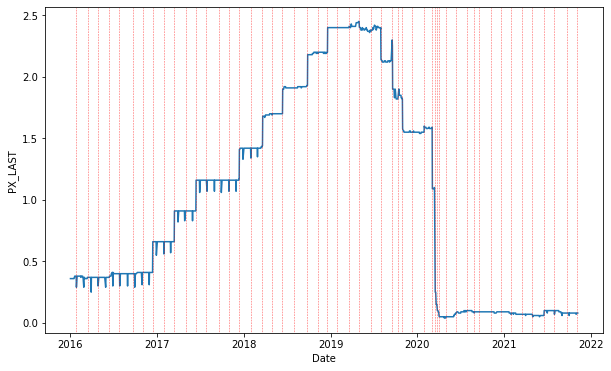

In [77]:
fig,ax=plt.subplots(figsize=(10,6))
sns.lineplot(data=ffr.reset_index()[lambda x:x.Date>'2016-01-01'],x='Date',y='PX_LAST',ax=ax)
for i in stat_total.loc['2016-01-01':].index:
    ax.axvline(i,color='red',linewidth=0.6,linestyle=':')

#### 10-year US treasuray bonds

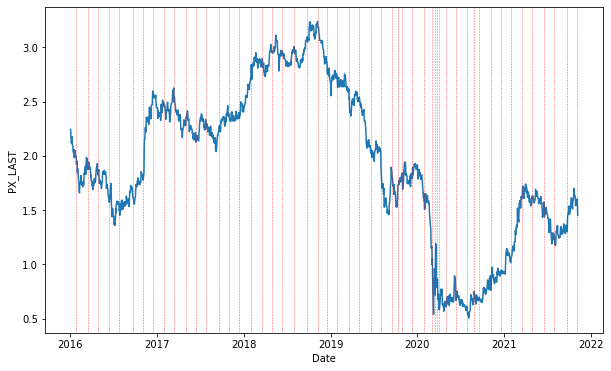

In [78]:
fig,ax=plt.subplots(figsize=(10,6))
sns.lineplot(data=us10year.reset_index()[lambda x:x.Date>'2016-01-01'],x='Date',y='PX_LAST',ax=ax)
for i in stat_total.loc['2016-01-01':].index:
    ax.axvline(i,color='red',linewidth=0.6,linestyle=':')

#### 3-year US treasuray bonds

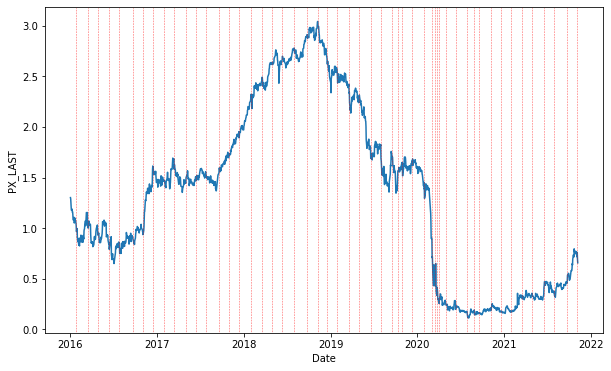

In [79]:
fig,ax=plt.subplots(figsize=(10,6))
sns.lineplot(data=us3year.reset_index()[lambda x:x.Date>'2016-01-01'],x='Date',y='PX_LAST',ax=ax)
for i in stat_total.loc['2016-01-01':].index:
    ax.axvline(i,color='red',linewidth=0.6,linestyle=':')

### 6.2 Random forest (RF) for original X and discrete Y
We first merge data and split data. When spliting data, it is not proper to use random split, as we cannot use data in the future to predict price in the past.

In [80]:
stat_disc=stat_total.merge(y_disc, left_index=True, right_index=True, how='left').dropna()

In [81]:
def train_test_split_time(df,X,y,test_size):
    df1=df.sort_index()
    cutoff=df1.index[int((1-test_size)*len(df1.index))]
    one_day=pd.Timedelta(days=1)
    return df1.loc[:cutoff][X],df1.loc[cutoff+one_day:][X],df1.loc[:cutoff][y],df1.loc[cutoff+one_day:][y]

#### Federal funds rate

In [82]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc, X=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)], 
                     y='ffr', test_size=0.3)

In [83]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(max_depth=2,n_estimators=16,max_features='sqrt',class_weight='balanced')
rf.fit(X_train,y_train)
print('Training accuracy:', rf.score(X_train, y_train))
print('Test accuracy:', rf.score(X_test, y_test))

Training accuracy: 0.6838235294117647
Test accuracy: 0.3793103448275862


In [84]:
from sklearn.model_selection import GridSearchCV
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
param_range=np.arange(1,20)
param_grid={'max_depth':param_range,'n_estimators':param_range}
gs=GridSearchCV(estimator=rf,
               param_grid=param_grid,
               scoring='accuracy',
               cv=4)
gs.fit(X_combined,y_combined)
print(gs.best_params_)

{'max_depth': 14, 'n_estimators': 8}


And then we use 5-fold to calculate the accuracy.

In [86]:
from sklearn.model_selection import cross_val_score
rf_best=gs.best_estimator_
scores=cross_val_score(estimator=rf_best,
                      X=X_combined,
                      y=y_combined,
                      cv=5)
print('CV accuracy scores of RF: %s'%scores)

CV accuracy scores of RF: [0.33333333 0.38461538 0.53846154 0.33333333 0.42105263]


In [87]:
(y_combined==0).sum()/len(y_combined)

0.2422680412371134

It can beat the two naive models: 
1. Randomly choose one.
2. Always predict that the price will not change.

Text(0.5, 1.0, 'Feature Importance')

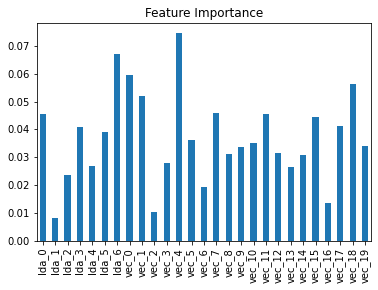

In [88]:
rf_best.fit(X_train,y_train)
fi=rf_best.feature_importances_
fig,ax=plt.subplots()
pd.Series(fi,index=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)]).plot.bar(ax=ax)
ax.set_title('Feature Importance')

In [89]:
def random_forest_grid(X_train, X_test, y_train, y_test):
    X_combined = np.vstack((X_train, X_test))
    y_combined = np.hstack((y_train, y_test))
    param_range=np.arange(1,20)
    param_grid={'max_depth':param_range,'n_estimators':param_range}
    gs=GridSearchCV(estimator=rf,
               param_grid=param_grid,
               scoring='accuracy',
               cv=4)
    gs.fit(X_combined,y_combined)
    return gs

def random_forest_test(X_train, X_test, y_train, y_test, estimator):
    X_combined = np.vstack((X_train, X_test))
    y_combined = np.hstack((y_train, y_test))
    return cross_val_score(estimator=estimator,
                      X=X_combined,
                      y=y_combined,
                      cv=5)

#### 10-year treasury bond

In [90]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc, X=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)], 
                     y='us10year', test_size=0.3)

In [91]:
gs=random_forest_grid(X_train, X_test, y_train, y_test)
print(gs.best_params_)

{'max_depth': 8, 'n_estimators': 10}


In [93]:
rf_best=gs.best_estimator_
scores=random_forest_test(X_train, X_test, y_train, y_test,rf_best)
print('CV accuracy scores of RF: %s'%scores)

CV accuracy scores of RF: [0.43589744 0.48717949 0.56410256 0.46153846 0.55263158]


In [94]:
y_combined=np.hstack((y_train, y_test))
(y_combined==0).sum()/len(y_combined)

0.09278350515463918

It can beat the two naive models: 
1. Randomly choose one.
2. Always predict that the price will not change.

Text(0.5, 1.0, 'Feature Importance')

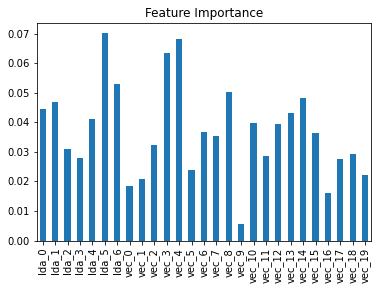

In [95]:
rf_best.fit(X_train,y_train)
fi=rf_best.feature_importances_
fig,ax=plt.subplots()
pd.Series(fi,index=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)]).plot.bar(ax=ax)
ax.set_title('Feature Importance')

#### 3-year treasury bond

In [96]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc, X=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)], 
                     y='us3year', test_size=0.3)

In [97]:
gs=random_forest_grid(X_train, X_test, y_train, y_test)
print(gs.best_params_)

{'max_depth': 10, 'n_estimators': 18}


In [98]:
rf_best=gs.best_estimator_
scores=random_forest_test(X_train, X_test, y_train, y_test,rf_best)
print('CV accuracy scores of RF: %s'%scores)

CV accuracy scores of RF: [0.53846154 0.46153846 0.51282051 0.48717949 0.55263158]


In [99]:
y_combined=np.hstack((y_train, y_test))
(y_combined==0).sum()/len(y_combined)

0.07216494845360824

It can also beat the two naive models: 
1. Randomly choose one.
2. Always predict that the price will not change.

Text(0.5, 1.0, 'Feature Importance')

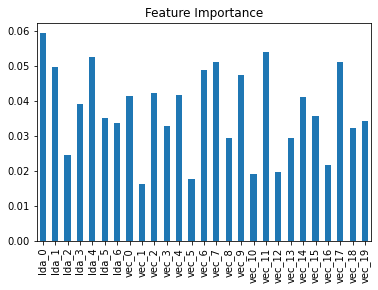

In [100]:
rf_best.fit(X_train,y_train)
fi=rf_best.feature_importances_
fig,ax=plt.subplots()
pd.Series(fi,index=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)]).plot.bar(ax=ax)
ax.set_title('Feature Importance')

###  6.3 RF for principal components of X and discrete Y
We first use the similar methods to merge and split data.

In [101]:
stat_disc_pca=stat_pca_total.merge(y_disc, left_index=True, right_index=True, how='left').dropna()

#### Federal funds rate

In [102]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc_pca, X=list(range(3)), y='ffr', test_size=0.3)

In [103]:
gs=random_forest_grid(X_train, X_test, y_train, y_test)
print(gs.best_params_)

{'max_depth': 1, 'n_estimators': 6}


In [104]:
rf_best=gs.best_estimator_
scores=random_forest_test(X_train, X_test, y_train, y_test,rf_best)
print('CV accuracy scores of RF: %s'%scores)

CV accuracy scores of RF: [0.38461538 0.33333333 0.33333333 0.46153846 0.23684211]


In [107]:
y_combined=np.hstack((y_train, y_test))
(y_combined==0).sum()/len(y_combined)

0.2422680412371134

The accuracy is lower than that of the original data.

Text(0.5, 1.0, 'Feature Importance')

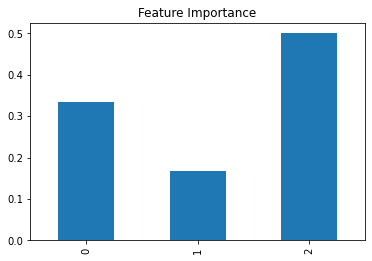

In [108]:
rf_best.fit(X_train,y_train)
fi=rf_best.feature_importances_
fig,ax=plt.subplots()
pd.Series(fi,index=range(3)).plot.bar(ax=ax)
ax.set_title('Feature Importance')

#### 10-year treasury bond

In [109]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc_pca, X=list(range(3)), y='us10year', test_size=0.3)

In [110]:
gs=random_forest_grid(X_train, X_test, y_train, y_test)
print(gs.best_params_)

{'max_depth': 15, 'n_estimators': 6}


In [111]:
rf_best=gs.best_estimator_
scores=random_forest_test(X_train, X_test, y_train, y_test,rf_best)
print('CV accuracy scores of RF: %s'%scores)

CV accuracy scores of RF: [0.53846154 0.38461538 0.41025641 0.41025641 0.44736842]


In [112]:
y_combined=np.hstack((y_train, y_test))
(y_combined==0).sum()/len(y_combined)

0.09278350515463918

Text(0.5, 1.0, 'Feature Importance')

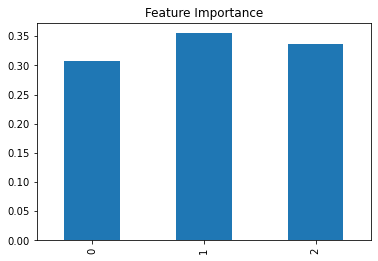

In [113]:
rf_best.fit(X_train,y_train)
fi=rf_best.feature_importances_
fig,ax=plt.subplots()
pd.Series(fi,index=range(3)).plot.bar(ax=ax)
ax.set_title('Feature Importance')

#### 3-year treasury bond

In [114]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc_pca, X=list(range(3)), y='us3year', test_size=0.3)

In [115]:
gs=random_forest_grid(X_train, X_test, y_train, y_test)
print(gs.best_params_)

{'max_depth': 14, 'n_estimators': 5}


In [116]:
rf_best=gs.best_estimator_
scores=random_forest_test(X_train, X_test, y_train, y_test,rf_best)
print('CV accuracy scores of RF: %s'%scores)

CV accuracy scores of RF: [0.58974359 0.48717949 0.48717949 0.46153846 0.55263158]


In [117]:
y_combined=np.hstack((y_train, y_test))
(y_combined==0).sum()/len(y_combined)

0.07216494845360824

Text(0.5, 1.0, 'Feature Importance')

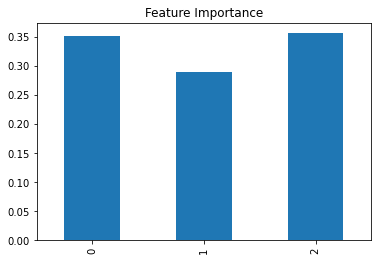

In [118]:
rf_best.fit(X_train,y_train)
fi=rf_best.feature_importances_
fig,ax=plt.subplots()
pd.Series(fi,index=range(3)).plot.bar(ax=ax)
ax.set_title('Feature Importance')

### 6.4 Support vector machine (SVM) for original X and discrete Y
#### Federal fund rate

In [119]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc, X=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)], 
                     y='ffr', test_size=0.3)

In [120]:
from sklearn.svm import SVC

svm=SVC(class_weight='balanced',kernel='rbf',C=1)
svm.fit(X_train,y_train)
print('Training accuracy:', svm.score(X_train, y_train))
print('Test accuracy:', svm.score(X_test, y_test))

Training accuracy: 0.8897058823529411
Test accuracy: 0.3275862068965517


In [121]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
svm_range=(np.ones((9,))*10)**np.arange(-4,5)
param_grid={'C':svm_range}
gs=GridSearchCV(estimator=svm,
               param_grid=param_grid,
               scoring='accuracy',
               cv=4)
gs.fit(X_combined,y_combined)
print(gs.best_params_)

{'C': 10.0}


In [122]:
svm_best=gs.best_estimator_
scores=cross_val_score(estimator=svm_best,
                      X=X_combined,
                      y=y_combined,
                      cv=5)
print('CV accuracy scores of SVM: %s'%scores)

CV accuracy scores of SVM: [0.33333333 0.30769231 0.51282051 0.23076923 0.34210526]


In [123]:
y_combined=np.hstack((y_train, y_test))
(y_combined==0).sum()/len(y_combined)

0.2422680412371134

The result of SVM is even better than Random Forest.

In [124]:
def svm_grid(X_train, X_test, y_train, y_test):
    X_combined = np.vstack((X_train, X_test))
    y_combined = np.hstack((y_train, y_test))
    svm_range=(np.ones((9,))*10)**np.arange(-4,5)
    param_grid={'C':svm_range}
    gs=GridSearchCV(estimator=svm,
                   param_grid=param_grid,
                   scoring='accuracy',
                   cv=4)
    gs.fit(X_combined,y_combined)
    return gs

def svm_test(X_train, X_test, y_train, y_test, estimator):
    X_combined = np.vstack((X_train, X_test))
    y_combined = np.hstack((y_train, y_test))
    return cross_val_score(estimator=estimator,
                      X=X_combined,
                      y=y_combined,
                      cv=5)

#### 10-year treasury bond

In [125]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc, X=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)], 
                     y='us10year', test_size=0.3)

In [126]:
gs=svm_grid(X_train, X_test, y_train, y_test)
print(gs.best_params_)

{'C': 10.0}


In [127]:
svm_best=gs.best_estimator_
scores=svm_test(X_train, X_test, y_train, y_test, svm_best)
print('CV accuracy scores of SVM: %s'%scores)

CV accuracy scores of SVM: [0.35897436 0.43589744 0.41025641 0.53846154 0.55263158]


In [128]:
y_combined=np.hstack((y_train, y_test))
(y_combined==0).sum()/len(y_combined)

0.09278350515463918

#### 3-year treasury bond

In [129]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc, X=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)], 
                     y='us3year', test_size=0.3)

In [130]:
gs=svm_grid(X_train, X_test, y_train, y_test)
print(gs.best_params_)

{'C': 1.0}


In [131]:
svm_best=gs.best_estimator_
scores=svm_test(X_train, X_test, y_train, y_test,svm_best)
print('CV accuracy scores of SVM: %s'%scores)

CV accuracy scores of SVM: [0.53846154 0.38461538 0.35897436 0.48717949 0.5       ]


In [132]:
y_combined=np.hstack((y_train, y_test))
(y_combined==0).sum()/len(y_combined)

0.07216494845360824

### 6.5 SVM for principal components of X and discrete Y

#### Federal funds rate

In [133]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc_pca, X=list(range(3)), 
                     y='ffr', test_size=0.3)

In [134]:
gs=svm_grid(X_train, X_test, y_train, y_test)
print(gs.best_params_)

{'C': 0.001}


In [135]:
svm_best=gs.best_estimator_
scores=svm_test(X_train, X_test, y_train, y_test,svm_best)
print('CV accuracy scores of SVM: %s'%scores)

CV accuracy scores of SVM: [0.41025641 0.41025641 0.38461538 0.38461538 0.23684211]


In [136]:
y_combined=np.hstack((y_train, y_test))
(y_combined==0).sum()/len(y_combined)

0.2422680412371134

#### 10-year treasury bond

In [145]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc_pca, X=list(range(3)), 
                     y='us10year', test_size=0.3)

In [146]:
gs=svm_grid(X_train, X_test, y_train, y_test)
print(gs.best_params_)

{'C': 0.01}


In [147]:
svm_best=gs.best_estimator_
scores=svm_test(X_train, X_test, y_train, y_test,svm_best)
print('CV accuracy scores of SVM: %s'%scores)

CV accuracy scores of SVM: [0.12820513 0.28205128 0.25641026 0.56410256 0.07894737]


In [148]:
y_combined=np.hstack((y_train, y_test))
(y_combined==0).sum()/len(y_combined)

0.09278350515463918

####  3-year treasury bond

In [149]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc_pca, X=list(range(3)), 
                     y='us3year', test_size=0.3)

In [150]:
gs=svm_grid(X_train, X_test, y_train, y_test)
print(gs.best_params_)

{'C': 10.0}


In [151]:
svm_best=gs.best_estimator_
scores=svm_test(X_train, X_test, y_train, y_test,svm_best)
print('CV accuracy scores of SVM: %s'%scores)

CV accuracy scores of SVM: [0.41025641 0.46153846 0.33333333 0.48717949 0.42105263]


In [152]:
y_combined=np.hstack((y_train, y_test))
(y_combined==0).sum()/len(y_combined)

0.07216494845360824

### 6.6 Dense neural network for original X and discrete Y

In [8]:
import keras
from keras import Sequential
from keras.layers import merge, Conv2D, MaxPooling2D, Input, Dense, Flatten, LSTM, Dropout
import pandas as pd
import numpy as np
from tqdm import tqdm

In [9]:
stat_disc = pd.read_excel("stat_disc.xlsx", header=0, index_col=0)
stat_cont = pd.read_excel("stat_cont.xlsx", header=0, index_col=0)

In [10]:
def train_test_split_time(df,X,y,test_size):
    df1=df.sort_index()
    cutoff=df1.index[int((1-test_size)*len(df1.index))]
    one_day=pd.Timedelta(days=1)
    return df1.loc[:cutoff][X],df1.loc[cutoff+one_day:][X],df1.loc[:cutoff][y],df1.loc[cutoff+one_day:][y]

In [11]:
class DenseModelClassification:
    def build_model():
        dense_model = Sequential()
        dense_model.add(Dense(32, activation='relu', input_shape=(len(X_train.iloc[0, :]), ), kernel_initializer=keras.initializers.ones()))
        dense_model.add(Dense(16, activation='relu'))
        dense_model.add(Dense(3, activation='softmax'))
        dense_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return dense_model

#### Federal funds rate

In [12]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc, X=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)], 
                     y='ffr', test_size=0.3)

In [13]:
y_train_reshape = pd.DataFrame(np.zeros([len(y_train), 3]), index=y_train.index)
y_test_reshape = pd.DataFrame(np.zeros([len(y_test), 3]), index=y_test.index)
for i in range(len(y_train)):
    y_train_reshape.iloc[i, y_train[i]+1] = 1
y_train = y_train_reshape

for i in range(len(y_test)):
    y_test_reshape.iloc[i, y_test[i] + 1] = 1
y_test = y_test_reshape

In [14]:
test_accuracy = []
n_iter = 10

In [15]:
for i in range(n_iter):
    dense_model = DenseModelClassification.build_model()
    dense_model.fit(X_train, y_train, epochs=100, verbose=0)
    prediction = dense_model.predict(X_test)
    prediction = (prediction == prediction.max(axis=1, keepdims=1)).astype(float)

    dev = prediction - y_test
    error = 0
    for i in range(len(y_test)):
        error += (abs(dev.iloc[i, 0]) + abs(dev.iloc[i, 1]) + abs(dev.iloc[i, 2]))/2
    test_accuracy.append(1- error / len(dev))
print('mean accuracy: ' + str(np.mean(test_accuracy)))
print('std of accuracy: ' + str(np.std(test_accuracy)))
print('coefficient of variation: ' + str(np.std(test_accuracy) / np.mean(test_accuracy)))

mean accuracy: 0.2862068965517241
std of accuracy: 0.035502172899955164
coefficient of variation: 0.12404373663839757


#### 10-year treasury bond

In [16]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc, X=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)], y='us10year', test_size=0.3)

In [17]:
y_train_reshape = pd.DataFrame(np.zeros([len(y_train), 3]), index=y_train.index)
y_test_reshape = pd.DataFrame(np.zeros([len(y_test), 3]), index=y_test.index)
for i in range(len(y_train)):
    y_train_reshape.iloc[i, y_train[i]+1] = 1
y_train = y_train_reshape

for i in range(len(y_test)):
    y_test_reshape.iloc[i, y_test[i] + 1] = 1
y_test = y_test_reshape

In [18]:
test_accuracy = []
n_iter = 10
for i in range(n_iter):
    dense_model = DenseModelClassification.build_model()
    dense_model.fit(X_train, y_train, epochs=100, verbose=0)
    prediction = dense_model.predict(X_test)
    prediction = (prediction == prediction.max(axis=1, keepdims=1)).astype(float)

    dev = prediction - y_test
    error = 0
    for i in range(len(y_test)):
        error += (abs(dev.iloc[i, 0]) + abs(dev.iloc[i, 1]) + abs(dev.iloc[i, 2]))/2
    test_accuracy.append(1- error / len(dev))
print('mean accuracy: ' + str(np.mean(test_accuracy)))
print('std of accuracy: ' + str(np.std(test_accuracy)))
print('coefficient of variation: ' + str(np.std(test_accuracy) / np.mean(test_accuracy)))

mean accuracy: 0.4344827586206897
std of accuracy: 0.015030686012209218
coefficient of variation: 0.034594436059846606


#### 3-year treasury bond

In [19]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_disc, X=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)], y='us3year', test_size=0.3)

In [20]:
y_train_reshape = pd.DataFrame(np.zeros([len(y_train), 3]), index=y_train.index)
y_test_reshape = pd.DataFrame(np.zeros([len(y_test), 3]), index=y_test.index)
for i in range(len(y_train)):
    y_train_reshape.iloc[i, y_train[i]+1] = 1
y_train = y_train_reshape

for i in range(len(y_test)):
    y_test_reshape.iloc[i, y_test[i] + 1] = 1
y_test = y_test_reshape

In [21]:
test_accuracy = []
n_iter = 10
for i in range(n_iter):
    dense_model = DenseModelClassification.build_model()
    dense_model.fit(X_train, y_train, epochs=100, verbose=0)
    prediction = dense_model.predict(X_test)
    prediction = (prediction == prediction.max(axis=1, keepdims=1)).astype(float)

    dev = prediction - y_test
    error = 0
    for i in range(len(y_test)):
        error += (abs(dev.iloc[i, 0]) + abs(dev.iloc[i, 1]) + abs(dev.iloc[i, 2]))/2
    test_accuracy.append(1- error / len(dev))
print('mean accuracy: ' + str(np.mean(test_accuracy)))
print('std of accuracy: ' + str(np.std(test_accuracy)))
print('coefficient of variation: ' + str(np.std(test_accuracy) / np.mean(test_accuracy)))

mean accuracy: 0.3706896551724138
std of accuracy: 0.028066932062240882
coefficient of variation: 0.0757154446330219


### 6.7 Dense neural network for original X and continuous Y

In [22]:
class DenseModelRegression:
    def build_model():
        dense_model = Sequential()
        dense_model.add(Dense(16, activation='relu', input_shape=(len(X_train.iloc[0, :]), ), kernel_initializer='random_normal'))
        dense_model.add(Dense(8, activation='relu'))
        dense_model.add(Dense(4, activation='relu'))
        dense_model.add(Dense(1))
        dense_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
        return dense_model

In [23]:
import matplotlib.pyplot as plt
def nn_plot(y_pred, y_test, title):
    plt.plot(y_test.index.values, y_test, color="navy", label="y_test")
    plt.plot(y_test.index.values, y_pred, color="red", label="y_pred")
    plt.title(title)
    plt.xlabel('date')
    plt.ylabel('y')
    plt.legend(loc="upper right")
    plt.show()

#### Federal funds rate

In [33]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_cont, X=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)], y='ffr', test_size=0.3)

In [34]:
test_error = []
n_iter = 10
for i in range(n_iter):
    dense_model = DenseModelRegression.build_model()
    dense_model.fit(X_train, y_train, epochs=100, verbose=0)
    prediction = dense_model.predict(X_test)[:, 0]
    error = 0
    for i in range(len(y_test)):
        error += (prediction - y_test)**2
    test_error.append(error / len(y_test))
print('MSE: ' + str(np.mean(test_error)))
print('std of MSE: ' + str(np.std(test_error)))

MSE: 0.005237788112579181
std of MSE: 0.018589859465028495


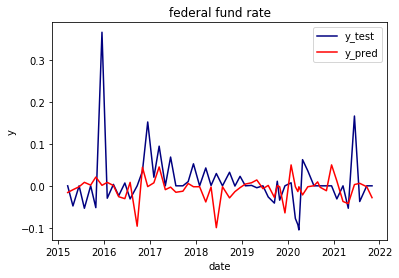

In [35]:
nn_plot(prediction, y_test, title='federal fund rate')

#### 10-year treasury bond

In [27]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_cont, X=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)], y='us10year', test_size=0.3)

In [28]:
test_error = []
n_iter = 10
for i in range(n_iter):
    dense_model = DenseModelRegression.build_model()
    dense_model.fit(X_train, y_train, epochs=100, verbose=0)
    prediction = dense_model.predict(X_test)[:, 0]
    error = 0
    for i in range(len(y_test)):
        error += (prediction - y_test)**2
    test_error.append(error / len(y_test))
print('MSE: ' + str(np.mean(test_error)))
print('std of MSE: ' + str(np.std(test_error)))

MSE: 0.0005807385955469502
std of MSE: 0.002005127501643277


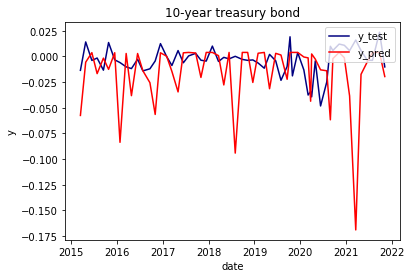

In [29]:
nn_plot(prediction, y_test, title='10-year treasury bond')

#### 3-year treasury bond

In [30]:
X_train, X_test, y_train, y_test =\
    train_test_split_time(stat_cont, X=['lda_'+str(i) for i in range(7)]+['vec_'+str(i) for i in range(20)], y='us3year', test_size=0.3)

In [31]:
test_error = []
n_iter = 10
for i in range(n_iter):
    dense_model = DenseModelRegression.build_model()
    dense_model.fit(X_train, y_train, epochs=100, verbose=0)
    prediction = dense_model.predict(X_test)[:, 0]
    error = 0
    for i in range(len(y_test)):
        error += (prediction - y_test)**2
    test_error.append(error / len(y_test))
print('MSE: ' + str(np.mean(test_error)))
print('std of MSE: ' + str(np.std(test_error)))

MSE: 0.0016729869010720148
std of MSE: 0.003351372567072802


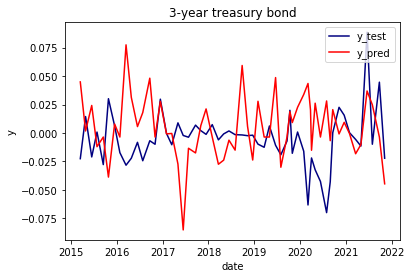

In [32]:
nn_plot(prediction, y_test, title='3-year treasury bond')

## 7. Explore Minutes
### 7.1 Similarities
##### Please see [Cosine Similarity.ipynb](https://github.com/XueyangHu/PHBS_MLF_2021/blob/master/Project/Cosine%20Similarity.ipynb) under the same repository.
### 7.2 Plot
Again, we use red line to mark the time when minutes were publicated. We only plot data after 2016.

We can find that the influence of minutes is quite difficult to identify.

In [153]:
mi=pd.read_excel('vec_min.xlsx')
mi['st_time']=pd.to_datetime(mi.file.str[11:])
mi['pub_time']=pd.to_datetime(mi.pub_time.astype(str))

#### Federal funds rate

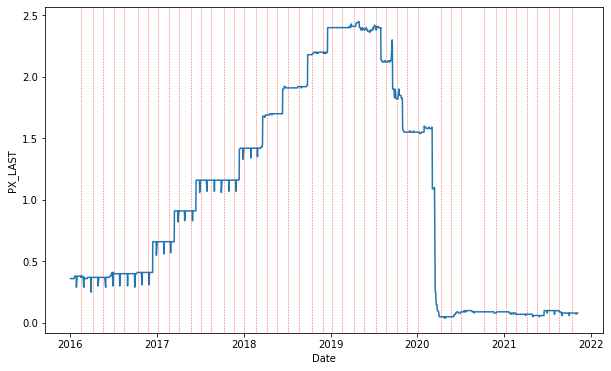

In [154]:
fig,ax=plt.subplots(figsize=(10,6))
sns.lineplot(data=ffr.reset_index()[lambda x:x.Date>'2016-01-01'],x='Date',y='PX_LAST',ax=ax)
for i in mi.pub_time:
    ax.axvline(i,color='red',linewidth=0.6,linestyle=':')

#### 10-year US treasury bonds

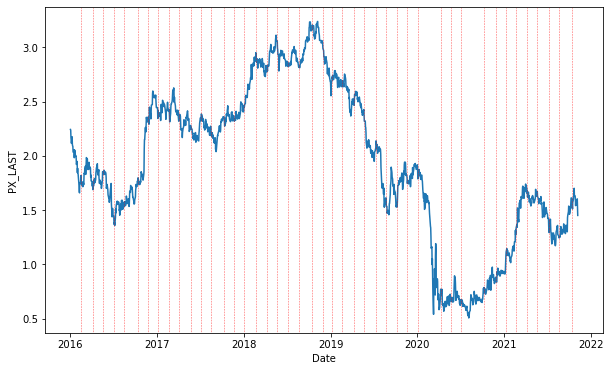

In [155]:
fig,ax=plt.subplots(figsize=(10,6))
sns.lineplot(data=us10year.reset_index()[lambda x:x.Date>'2016-01-01'],x='Date',y='PX_LAST',ax=ax)
for i in mi.pub_time:
    ax.axvline(i,color='red',linewidth=0.6,linestyle=':')

#### 3-year US treasury bonds

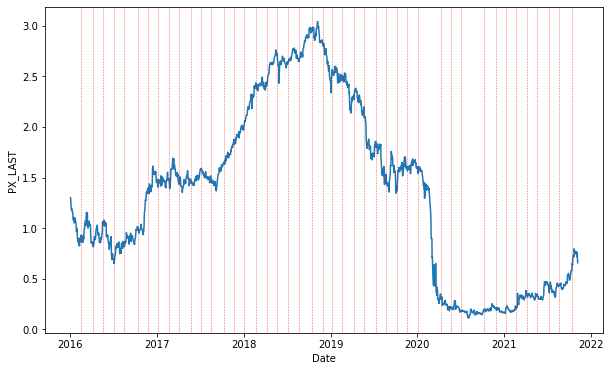

In [156]:
fig,ax=plt.subplots(figsize=(10,6))
sns.lineplot(data=us3year.reset_index()[lambda x:x.Date>'2016-01-01'],x='Date',y='PX_LAST',ax=ax)
for i in mi.pub_time:
    ax.axvline(i,color='red',linewidth=0.6,linestyle=':')

### 7.3 Statistical analysis of the influence of the publication of minutes
From 7.2, we can make a hypothesis that the influence of publication is not sigificant. In this subsection, we aim to test whether our hypothesis is right.

In [157]:
mi

date   pub_time         0         1         2         3         4  \
0   20160127 2016-02-17 -0.017573 -0.004033  0.017484  0.000018 -0.006594   
1   20160316 2016-04-06 -0.024023 -0.014612 -0.000676 -0.021333 -0.012202   
2   20160427 2016-05-18 -0.009483 -0.021400 -0.020217 -0.020622 -0.017765   
3   20160615 2016-07-06  0.005206 -0.024851 -0.021739  0.023006  0.021305   
4   20160727 2016-08-17  0.337611 -0.119590  0.032108  0.305054  0.142185   
5   20160921 2016-10-12  0.010702  0.015152 -0.024089 -0.006218  0.017446   
6   20161102 2016-11-23 -0.007434 -0.015474  0.017831 -0.007604 -0.021326   
7   20161214 2017-01-04  0.003255  0.022834 -0.001323 -0.003383  0.024815   
8   20170201 2017-02-22  0.010044 -0.009910  0.014483  0.001060  0.013946   
9   20170315 2017-04-05 -0.023711  0.023908  0.010165  0.019468  0.012558   
10  20170503 2017-05-24 -0.002111 -0.009511 -0.007092 -0.024089 -0.012778   
11  20170614 2017-07-05  0.001898  0.013251  0.006258  0.004533  0.015249   
12  20170726 2017-08-16 -0.005017 -0.005322  0.013292 -0.007059  0.021931   
13  20170920 2017-10-11 -0.015122  0.019740 -0.012665  0.019644  0.019218   
14  20171101 2017-11-22  0.001995 -0.014828 -0.022673  0.021460  0.019854   
15  20171213 2018-01-03  0.534868  0.003230 -0.103364  0.140276  0.021669   
16  20180131 2018-02-21  0.024541  0.001972 -0.022601  0.020762 -0.012214   
17  20180321 2018-04-11  0.024478 -0.016889  0.023725 -0.013193 -0.004211   
18  20180502 2018-05-23 -0.019404 -0.022376  0.021129  0.011972  0.008068   
19  20180613 2018-07-05  0.016192  0.016039 -0.009237 -0.012621 -0.002687   
20  20180801 2018-08-22 -0.004660 -0.022869 -0.016111  0.019498 -0.001850   
21  20180926 2018-10-17  0.000726  0.008997 -0.016371  0.019224 -0.003860   
22  20181108 2018-11-29  0.002875 -0.020307  0.004401 -0.009334  0.017068   
23  20181219 2019-01-09 -0.024799 -0.016827  0.017960  0.007462  0.014746   
24  20190130 2019-02-20  0.019455 -0.014452 -0.022806  0.005029  0.022116   
25  20190320 2019-04-10  0.009279  0.014185  0.003775 -0.009014  0.010559   
26  20190501 2019-05-22  0.014390 -0.011543 -0.010259 -0.016113 -0.013887   
27  20190619 2019-07-10 -0.016437 -0.015521  0.016279 -0.024497  0.017323   
28  20190731 2019-08-21 -0.020427  0.008508 -0.014196  0.010369 -0.002562   
29  20190918 2019-10-09  0.122826  0.021327  0.020049  0.045044 -0.002499   
30  20191030 2019-11-20 -0.021329 -0.014730 -0.012887 -0.013536  0.017623   
31  20191211 2020-01-03  0.053249 -0.037912  0.018956  0.058972 -0.025937   
32  20200315 2020-04-08 -0.006418 -0.017591  0.006204  0.008001 -0.000391   
33  20200429 2020-05-20 -0.015987 -0.018558 -0.019036 -0.021649  0.005414   
34  20200610 2020-07-01  0.411336 -0.024350  0.199642  0.203611 -0.267076   
35  20200916 2020-10-07  0.326588  0.007635  0.145801  0.198397 -0.265366   
36  20201105 2020-11-25 -0.014333 -0.000964 -0.022064  0.004765 -0.020168   
37  20201216 2021-01-06  0.016753  0.017981  0.004167  0.016850 -0.013213   
38  20210127 2021-02-17  0.006382  0.024966 -0.021039 -0.011800  0.023131   
39  20210317 2021-04-07  0.022395 -0.024574 -0.010913  0.023169  0.011805   
40  20210428 2021-05-19 -0.010147 -0.022327  0.013350 -0.005415 -0.010108   
41  20210616 2021-07-07 -0.015564 -0.021930 -0.014946  0.019411 -0.024200   
42  20210728 2021-08-18 -0.020147  0.012574 -0.010502 -0.016049 -0.014248   
43  20210922 2021-10-13 -0.003135 -0.006111 -0.012854  0.001940 -0.001528   

           5         6         7  ...        13        14        15        16  \
0  -0.022385 -0.005872  0.007935  ...  0.008354 -0.020780  0.020542 -0.002247   
1   0.023846  0.022783  0.009473  ... -0.014480 -0.006666 -0.009904  0.011303   
2  -0.013586 -0.010085  0.024625  ... -0.002154  0.007562 -0.017655 -0.003884   
3   0.015038  0.011444 -0.001719  ...  0.014038  0.003720  0.007634 -0.015104   
4  -0.176148 -0.243425  0.138302  ... -0.119060  0.055232 -0.276821  0.136149   
5  -0.021784  0.023812 -0.002408  ...  0.008840 -0.02129

In [158]:
dt=y_cont.sort_index().loc['2016-01-01':].reset_index().merge(
    mi[['pub_time']],left_on='Date',right_on='pub_time',how='left')
dt=dt.merge(mi[['st_time']],left_on='Date',right_on='st_time',how='left')
dt['minutes_pub']=np.where(pd.isna(dt.pub_time),0,1)
dt['statements_pub']=np.where(pd.isna(dt.st_time),0,1)
dt

Date       ffr   us3year  us10year pub_time st_time  minutes_pub  \
0    2016-01-04  0.077273 -0.008293 -0.007320      NaT     NaT            0   
1    2016-01-05  0.071429 -0.015872 -0.010887      NaT     NaT            0   
2    2016-01-06  0.000000 -0.020216 -0.012136      NaT     NaT            0   
3    2016-01-07  0.000000 -0.016175 -0.006520      NaT     NaT            0   
4    2016-01-08  0.000000 -0.010070 -0.002149      NaT     NaT            0   
...         ...       ...       ...       ...      ...     ...          ...   
1464 2021-10-28 -0.015625 -0.001997 -0.003287      NaT     NaT            0   
1465 2021-10-29  0.000000 -0.009001 -0.001346      NaT     NaT            0   
1466 2021-11-01  0.016667 -0.007377  0.001604      NaT     NaT            0   
1467 2021-11-02  0.016667 -0.011862  0.001754      NaT     NaT            0   
1468 2021-11-03  0.000000 -0.022192 -0.010227      NaT     NaT            0   

      statements_pub  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
1464               0  
1465               0  
1466               0  
1467               0  
1468               0  

[1469 rows x 8 columns]

In [159]:
from statsmodels.formula.api import ols
lm=ols('ffr~minutes_pub+statements_pub',data=dt).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ffr   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     8.512
Date:                Sun, 21 Nov 2021   Prob (F-statistic):           0.000211
Time:                        16:05:59   Log-Likelihood:                 3715.8
No. Observations:                1469   AIC:                            -7426.
Df Residuals:                    1466   BIC:                            -7410.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0001      0.001     -0.285      0.776      -0.001       0.001
minutes_pub        0.0008      0.003      0.274      0.784      -0.005       0.007
statements_pub     0.0123      0.003      4.123      0.000       0.006       0.018
==============================================================================
Omnibus:                      575.419   Durbin-Watson:                   0.450
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            65195.164
Skew:                          -0.809   Prob(JB):                         0.00
Kurtosis:                      35.596   Cond. No.                         6.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [160]:
lm=ols('us10year~minutes_pub+statements_pub',data=dt).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               us10year   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.228
Date:                Sun, 21 Nov 2021   Prob (F-statistic):              0.293
Time:                        16:06:14   Log-Likelihood:                 4321.5
No. Observations:                1469   AIC:                            -8637.
Df Residuals:                    1466   BIC:                            -8621.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0003      0.000      0.793      0.428      -0.000       0.001
minutes_pub        0.0002      0.002      0.081      0.936      -0.004       0.004
statements_pub    -0.0031      0.002     -1.562      0.119      -0.007       0.001
==============================================================================
Omnibus:                      322.303   Durbin-Watson:                   0.506
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7840.587
Skew:                           0.396   Prob(JB):                         0.00
Kurtosis:                      14.290   Cond. No.                         6.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can find the publication of minutes do not have stastically significant influence on all the financial market variables.

# References

<font color=black size=3 face=times><p>[1] Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent Dirichlet Allocation. *the Journal of Machine Learning Research*, *3*, 993-1022.</p>
    <p>[2] Le, Q., & Mikolov, T. (2014). Distributed Representations of Sentences and Documents. *Proceedings of the 31st International Conference on Machine Learning, 14*, 1188-1196.<br>